Let's put all the pieces together, and train a model:

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

First, we'll need training and test datasets. If you haven't already, run the cell below to make sure the dataset is downloaded. (It may take a minute.)

In [2]:
BATCH_SIZE = 16
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform_train = transforms.Compose([
        transforms.RandomRotation(15),
        transforms.RandomCrop(32,padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

trainset = torchvision.datasets.SVHN(root='./data', split='train',
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.SVHN(root='./data', split='train',
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=2)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
classes_with_rejection = classes + ('UNKNOWN',)

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/train_32x32.mat


We'll run our check on the output from `DataLoader`:

         2          7          4          5          3          0          9          7
         9          6          1          1          8          2          2          1


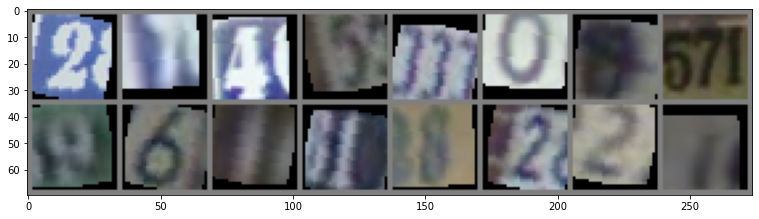

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize = (13,13))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(0 , BATCH_SIZE//2)))
print(' '.join('%10s' % classes[labels[j]] for j in range(BATCH_SIZE//2 , BATCH_SIZE)))

In [4]:
import sys 
sys.path.append('..')
use_cuda = torch.cuda.is_available()
print("use_cuda", use_cuda)

use_cuda True


In [5]:
model_path = "svhn.pth"
model = torch.load(model_path)
if use_cuda: model = model.cuda()

In [6]:
class SelfAdativeTraining():
    def __init__(self, num_examples=50000, num_classes=10, mom=0.9):
        self.prob_history = torch.zeros(num_examples, num_classes)
        self.updated = torch.zeros(num_examples, dtype=torch.int)
        self.mom = mom
        self.num_classes = num_classes

    def _update_prob(self, prob, index, y):
        onehot = torch.zeros_like(prob)
        onehot[torch.arange(y.shape[0]), y] = 1
        prob_history = self.prob_history[index].clone().to(prob.device)

        # if not inited, use onehot label to initialize runnning vector
        cond = (self.updated[index] == 1).to(prob.device).unsqueeze(-1).expand_as(prob)
        prob_mom = torch.where(cond, prob_history, onehot)

        # momentum update
        prob_mom = self.mom * prob_mom + (1 - self.mom) * prob

        self.updated[index] = 1
        self.prob_history[index] = prob_mom.to(self.prob_history.device)

        return prob_mom

    def __call__(self, logits, y, index):
        prob = F.softmax(logits.detach()[:, :self.num_classes], dim=1)
        prob = self._update_prob(prob, index, y)

        soft_label = torch.zeros_like(logits)
        soft_label[torch.arange(y.shape[0]), y] = prob[torch.arange(y.shape[0]), y]
        soft_label[:, -1] = 1 - prob[torch.arange(y.shape[0]), y]
        soft_label = F.normalize(soft_label, dim=1, p=1)
        loss = torch.sum(-F.log_softmax(logits, dim=1) * soft_label, dim=1)
        return torch.mean(loss)

In [7]:
criterion = SelfAdativeTraining(num_examples=len(trainset), num_classes=len(classes), mom=.99)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=.9, weight_decay=5e-4)

In [8]:
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

True labels
         9          4          1          1          5          1          3          3
         3          5          4          1          8          1          2          1
Predicted labels
         9          4          1          1          5          1          3          3
         3          5          4          2          8          1    UNKNOWN          1


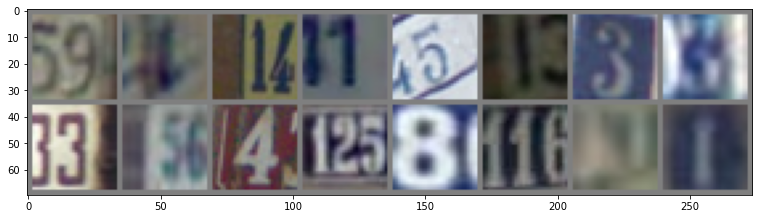

In [9]:
# get some random training images
found_doubt = False
dataiter = iter(testloader)
while found_doubt == False:
    images, labels = dataiter.next()
    initial_outputs = model(images).cpu()
    values, predictions = initial_outputs.data.max(1)
    outputs = F.softmax(initial_outputs, dim=1)
    reservation = outputs[:,-1]
    found_doubt = np.any(np.argmax(outputs.detach().numpy(), axis=1) == 10)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("True labels")
print(' '.join('%10s' % classes[labels[j]] for j in range(0 , BATCH_SIZE//2)))
print(' '.join('%10s' % classes[labels[j]] for j in range(BATCH_SIZE//2 , BATCH_SIZE)))
print("Predicted labels")
print(' '.join('%10s' % classes_with_rejection[predictions[j]] for j in range(0 , BATCH_SIZE//2)))
print(' '.join('%10s' % classes_with_rejection[predictions[j]] for j in range(BATCH_SIZE//2 , BATCH_SIZE)))

In [10]:
print("Values", values)
print("predictions indices", np.where(predictions == 10))
print("predictions", values[predictions == 10])
print("Probs")
print(classes_with_rejection)
print(outputs[np.where(predictions == 10)].detach().numpy())

Values tensor([6.7722, 7.0396, 7.0900, 7.0538, 6.7782, 7.0838, 6.9887, 7.0827, 6.8047,
        6.9327, 7.0187, 5.2997, 6.8475, 7.1310, 3.8771, 7.1090])
predictions indices (array([14]),)
predictions tensor([3.8771])
Probs
('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'UNKNOWN')
[[0.0097 0.1061 0.0589 0.0895 0.0014 0.0076 0.0005 0.0084 0.001  0.0273
  0.6895]]


No misclassification found

In [11]:
# print("Misclassifications", np.where(predictions.eq(labels.data).numpy() == False))
# print("Probs of misclassification")
# print(classes_with_rejection)
# print(outputs[np.where(predictions.eq(labels.data).numpy() == False)].detach().numpy())

In [12]:
print(reservation.detach().numpy() )

[0.1578 0.1792 0.135  0.1391 0.1589 0.1217 0.1546 0.1568 0.1544 0.1529
 0.1564 0.3844 0.1611 0.1209 0.6895 0.1327]


In [13]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[k-1].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

class AverageMeter(object):
    """Computes and stores the average and current value
       Imported from https://github.com/pytorch/examples/blob/master/imagenet/main.py#L247-L262
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [14]:
abstention_results = []
top1 = AverageMeter()
top5 = AverageMeter()
generator = iter(testloader)
print("Total batches ", len(generator))
for batch_idx in range(len(generator)):
    batch_data = next(generator)
    inputs, labels = batch_data
    
    if use_cuda:
        inputs = inputs.cuda()
    inputs, labels = torch.autograd.Variable(inputs), torch.autograd.Variable(labels)

    with torch.no_grad():
        outputs = model(inputs).cpu()
        values, predictions = outputs.data.max(1)
        outputs = F.softmax(outputs, dim=1)
        outputs, reservation = outputs[:,:-1], outputs[:,-1]
        print("Batch: ", batch_idx)
        abstention_result = list(zip(list( reservation.numpy() ),list( predictions.eq(labels.data).numpy() )))
        print(abstention_result)
        abstention_results.extend(abstention_result)
        prec1, prec5 = accuracy(outputs.data, labels.data, topk=(1, 5))
        top1.update(prec1.item(), inputs.size(0))
        top5.update(prec5.item(), inputs.size(0))
    
# sort the abstention results according to their reservations, from high to low
abstention_results.sort(key = lambda x: x[0], reverse=True)
# get the "correct or not" list for the sorted results
sorted_correct = list(map(lambda x: int(x[1]), abstention_results))

Total batches  4579
Batch:  0
[(0.15448993, True), (0.15478042, True), (0.13923766, True), (0.16876408, True), (0.21374819, True), (0.14396599, True), (0.19911742, True), (0.17384042, True), (0.12710766, True), (0.17421119, True), (0.14278208, True), (0.15352847, True), (0.1396132, True), (0.15041035, True), (0.157243, True), (0.1345118, True)]
Batch:  1
[(0.15274744, True), (0.15402734, True), (0.1518516, True), (0.15987633, True), (0.14405064, True), (0.14327036, True), (0.16374084, True), (0.15136123, True), (0.16191371, True), (0.14141232, True), (0.14743078, True), (0.16278502, True), (0.16058488, True), (0.18821657, True), (0.15637536, True), (0.15913954, True)]
Batch:  2
[(0.14685662, True), (0.15579517, True), (0.15468855, True), (0.16062497, True), (0.16025956, True), (0.15324946, True), (0.14710484, True), (0.15247592, True), (0.12219027, True), (0.20753701, True), (0.267799, True), (0.16553733, True), (0.15651226, True), (0.15229511, True), (0.15627176, True), (0.151716, Tru

Batch:  40
[(0.13559498, True), (0.16146646, True), (0.3927159, False), (0.15853246, True), (0.16140021, True), (0.1521936, True), (0.1520969, True), (0.1522492, True), (0.15960646, True), (0.15966314, True), (0.1628056, True), (0.3808172, True), (0.1468179, True), (0.14974378, True), (0.1556188, True), (0.1621282, True)]
Batch:  41
[(0.13386473, True), (0.15187332, True), (0.1649732, True), (0.1540987, True), (0.16570897, True), (0.15485454, True), (0.1539572, True), (0.15428923, True), (0.13226658, True), (0.1481801, True), (0.16532178, True), (0.2298927, True), (0.15310234, True), (0.15977369, True), (0.16639593, True), (0.15684497, True)]
Batch:  42
[(0.16200736, True), (0.16117865, True), (0.24793443, False), (0.13578059, True), (0.16902597, True), (0.18590546, True), (0.15133606, True), (0.1214383, True), (0.153225, True), (0.15428819, True), (0.16085504, True), (0.18108363, True), (0.16275868, True), (0.15628478, True), (0.19679104, True), (0.16008374, True)]
Batch:  43
[(0.1579

Batch:  86
[(0.16073866, True), (0.1554274, True), (0.15824825, True), (0.14743125, True), (0.15177797, True), (0.18022011, True), (0.13195051, True), (0.16567011, True), (0.15379366, True), (0.16364513, True), (0.16489011, True), (0.1553539, True), (0.16979009, True), (0.1536104, True), (0.15789865, True), (0.1762271, False)]
Batch:  87
[(0.13042794, True), (0.16820127, True), (0.14463775, True), (0.26052302, True), (0.17108372, True), (0.15805034, True), (0.16076396, True), (0.16979721, True), (0.15339257, True), (0.16304828, True), (0.1478813, True), (0.15200144, True), (0.15863174, True), (0.22385103, True), (0.1609665, True), (0.3325984, True)]
Batch:  88
[(0.16525403, True), (0.15949991, True), (0.1508247, True), (0.22721021, True), (0.16822085, True), (0.15797809, True), (0.29992473, True), (0.19114089, True), (0.15731138, True), (0.16561563, True), (0.15699826, True), (0.16104947, True), (0.14300872, True), (0.16701537, True), (0.13493364, True), (0.15182649, True)]
Batch:  89


Batch:  111
[(0.1555507, True), (0.1513671, True), (0.20641111, True), (0.13763908, True), (0.14766017, True), (0.18168278, True), (0.16020279, True), (0.15664116, True), (0.15907203, True), (0.12432872, True), (0.15169764, True), (0.15257604, True), (0.14588314, True), (0.155474, True), (0.16285895, True), (0.17873512, True)]
Batch:  112
[(0.15031387, True), (0.15791056, True), (0.14565578, True), (0.15809034, True), (0.15955581, True), (0.14578564, False), (0.3463469, True), (0.15083988, True), (0.1621129, True), (0.16501524, True), (0.15319608, True), (0.16505755, True), (0.16167417, True), (0.15430576, True), (0.15377773, True), (0.16684769, True)]
Batch:  113
[(0.17336023, True), (0.13835664, True), (0.17299895, True), (0.16473301, True), (0.15396291, True), (0.15375549, True), (0.15364169, True), (0.14354374, True), (0.1530271, True), (0.15237607, True), (0.25357485, True), (0.13447069, True), (0.16535588, True), (0.41482344, True), (0.14532083, True), (0.15336117, True)]
Batch: 

Batch:  156
[(0.15347853, True), (0.14762387, True), (0.18887194, True), (0.15614834, True), (0.12052622, True), (0.14787969, True), (0.15873331, True), (0.14632605, True), (0.1814783, True), (0.2695945, True), (0.16124915, True), (0.15746011, True), (0.1730056, True), (0.15766326, True), (0.1930757, True), (0.15798974, True)]
Batch:  157
[(0.15518385, True), (0.1581569, True), (0.15972047, True), (0.1681857, True), (0.15053833, True), (0.11845695, True), (0.15420346, True), (0.42480162, True), (0.15716945, True), (0.16796437, True), (0.20801541, True), (0.14912982, True), (0.15330914, True), (0.14658198, True), (0.15794522, True), (0.17256646, True)]
Batch:  158
[(0.15566835, True), (0.15469287, True), (0.1482114, True), (0.15845913, True), (0.17306614, True), (0.15090936, True), (0.13298456, True), (0.152037, True), (0.15361586, True), (0.1523935, True), (0.14918864, True), (0.1572618, True), (0.1712207, True), (0.14322163, True), (0.20549077, True), (0.15414672, True)]
Batch:  159
[

Batch:  181
[(0.14313251, True), (0.15309663, True), (0.12643674, True), (0.1352148, True), (0.15405692, True), (0.16893496, True), (0.13033198, True), (0.17147364, True), (0.15226208, True), (0.13863893, True), (0.15396327, True), (0.1257723, True), (0.5653579, False), (0.15557107, True), (0.14731431, True), (0.1666501, True)]
Batch:  182
[(0.15514286, True), (0.15368654, True), (0.1648194, True), (0.1533025, True), (0.1655089, True), (0.1665238, True), (0.16434729, True), (0.17938143, True), (0.15542805, True), (0.15205431, True), (0.13537543, True), (0.15912871, True), (0.15904938, True), (0.15488873, True), (0.15165019, True), (0.15473506, True)]
Batch:  183
[(0.16573757, True), (0.15998863, True), (0.15449321, True), (0.15566628, True), (0.15099409, True), (0.15721975, True), (0.1698525, True), (0.16141589, True), (0.27739114, True), (0.15118805, True), (0.1626869, True), (0.14070736, True), (0.14607848, True), (0.13517906, True), (0.18140107, True), (0.13896258, True)]
Batch:  18

Batch:  206
[(0.15518391, True), (0.16104794, True), (0.14753596, True), (0.16478907, True), (0.14333116, True), (0.1561587, True), (0.14926316, True), (0.14969458, True), (0.12059952, True), (0.15512496, True), (0.15629713, True), (0.15930507, True), (0.16248251, True), (0.15429196, True), (0.1535374, True), (0.15201949, True)]
Batch:  207
[(0.17319739, True), (0.16291486, True), (0.16912283, True), (0.15436418, True), (0.157018, True), (0.16534267, True), (0.14943641, True), (0.15424585, True), (0.15506355, True), (0.16150242, True), (0.16172895, True), (0.16673774, True), (0.13899523, True), (0.15117915, True), (0.15215747, True), (0.15766096, True)]
Batch:  208
[(0.13234156, True), (0.15854488, True), (0.17665128, True), (0.15674911, True), (0.1529929, True), (0.15896223, True), (0.13418671, True), (0.14096372, True), (0.17409156, True), (0.15103321, True), (0.160861, True), (0.19684844, True), (0.1257996, True), (0.1555663, True), (0.15370525, True), (0.16029099, True)]
Batch:  20

Batch:  231
[(0.37988114, True), (0.15873994, True), (0.1607965, True), (0.19507219, True), (0.1538877, True), (0.15491599, True), (0.17894392, True), (0.2096966, True), (0.16481517, True), (0.15552258, True), (0.15156862, True), (0.17527823, True), (0.13730864, True), (0.16492528, True), (0.16640061, True), (0.19336055, True)]
Batch:  232
[(0.1619813, True), (0.15122482, True), (0.1620378, True), (0.15975308, True), (0.212546, True), (0.16925885, True), (0.15888803, True), (0.16188574, True), (0.1635833, True), (0.15656658, True), (0.15292507, True), (0.15286833, True), (0.13959965, True), (0.28771815, True), (0.14384021, True), (0.13630943, True)]
Batch:  233
[(0.15265921, True), (0.24391837, True), (0.1602273, True), (0.12578177, True), (0.18211372, True), (0.16357768, True), (0.14894898, True), (0.15427896, True), (0.1741891, True), (0.16137186, True), (0.16882898, True), (0.13962929, True), (0.16007511, True), (0.16568239, True), (0.16375321, True), (0.15127312, True)]
Batch:  234

Batch:  258
[(0.15695837, True), (0.15417773, True), (0.16823919, True), (0.14725442, True), (0.1961824, True), (0.14284241, True), (0.2076498, True), (0.14481819, True), (0.16515552, True), (0.19908492, True), (0.18094565, True), (0.18119197, True), (0.16733427, True), (0.14813673, True), (0.15191658, True), (0.15538105, True)]
Batch:  259
[(0.1585183, True), (0.16297273, True), (0.2683642, True), (0.15471537, True), (0.13377607, True), (0.15232065, True), (0.15651613, True), (0.15454118, True), (0.15110148, True), (0.16310255, True), (0.14982569, True), (0.25844854, True), (0.16086024, True), (0.15711528, True), (0.1320095, True), (0.16441032, True)]
Batch:  260
[(0.16040295, True), (0.14762507, True), (0.1317416, True), (0.15970753, True), (0.15444924, True), (0.15437873, True), (0.16108744, True), (0.20988701, True), (0.20455177, True), (0.15085258, True), (0.15117235, True), (0.1632591, True), (0.15030307, True), (0.15768555, True), (0.14684336, True), (0.1545941, True)]
Batch:  2

Batch:  306
[(0.12636648, True), (0.1602258, True), (0.120558076, True), (0.17589533, True), (0.15309925, True), (0.15301684, True), (0.21204083, True), (0.15666188, True), (0.16406247, True), (0.19445038, True), (0.118020736, True), (0.12932248, True), (0.16136189, True), (0.14783828, True), (0.1537759, True), (0.15524422, True)]
Batch:  307
[(0.151133, True), (0.16294527, True), (0.12783903, True), (0.20632744, True), (0.14355794, True), (0.17168997, True), (0.16339408, True), (0.1374901, True), (0.13583364, True), (0.15494804, True), (0.16031772, True), (0.1549972, True), (0.15399408, True), (0.26112488, True), (0.1560332, True), (0.15371725, True)]
Batch:  308
[(0.15028802, True), (0.15450974, True), (0.16358729, True), (0.15534487, True), (0.17306392, True), (0.2267395, True), (0.17049284, True), (0.13231973, True), (0.14885423, True), (0.15170458, True), (0.1450001, True), (0.1628893, True), (0.14090407, True), (0.1547476, True), (0.16544461, True), (0.14604911, True)]
Batch:  30

Batch:  354
[(0.15900819, True), (0.124440506, True), (0.1611326, True), (0.19609162, True), (0.15067524, True), (0.17117505, True), (0.16864629, True), (0.15325019, True), (0.14564385, True), (0.15813866, True), (0.15859932, True), (0.16646998, True), (0.20599276, True), (0.16141298, True), (0.14303298, True), (0.1441689, True)]
Batch:  355
[(0.1972949, True), (0.18814678, True), (0.19051126, True), (0.2716248, True), (0.15870991, True), (0.16159593, True), (0.15277058, True), (0.15976606, True), (0.16220742, True), (0.15964481, True), (0.15254945, True), (0.15363786, True), (0.15534095, True), (0.16601595, True), (0.15659301, True), (0.15944108, True)]
Batch:  356
[(0.18134035, True), (0.17797607, True), (0.14107694, True), (0.16002326, True), (0.16059797, True), (0.15450086, True), (0.2139864, True), (0.1276245, True), (0.16027512, True), (0.16888276, True), (0.14774096, True), (0.1285207, True), (0.15398155, True), (0.14951754, True), (0.16539554, True), (0.16514994, True)]
Batch: 

Batch:  379
[(0.16133827, True), (0.15659837, True), (0.14863524, True), (0.14816052, True), (0.15473199, True), (0.14823525, True), (0.15341642, True), (0.15434282, True), (0.15538912, True), (0.16433612, True), (0.16649078, True), (0.15955804, True), (0.18008031, True), (0.12553261, True), (0.14423732, True), (0.13913476, True)]
Batch:  380
[(0.15994667, True), (0.14562853, True), (0.1668132, True), (0.15426995, True), (0.14913736, True), (0.16332258, True), (0.1443999, True), (0.20806506, True), (0.15134557, True), (0.23498487, True), (0.16091602, True), (0.19173248, True), (0.20813036, True), (0.16340692, True), (0.15711772, True), (0.2141036, True)]
Batch:  381
[(0.15897745, True), (0.15875134, True), (0.12856865, True), (0.12402125, True), (0.14026657, True), (0.1545708, True), (0.15370254, True), (0.1563165, True), (0.28525805, True), (0.15234052, True), (0.15126279, True), (0.16665937, True), (0.15465763, True), (0.16305614, True), (0.15374312, True), (0.15823714, True)]
Batch:

Batch:  404
[(0.15327714, True), (0.16052857, True), (0.15079702, True), (0.17476562, True), (0.16075173, True), (0.15984234, True), (0.1581663, True), (0.16806471, True), (0.14669234, True), (0.13153315, True), (0.15968718, True), (0.14861214, True), (0.18066247, True), (0.1376895, True), (0.14642379, True), (0.14318818, True)]
Batch:  405
[(0.15394397, True), (0.1584846, True), (0.14905088, True), (0.14682543, True), (0.16214965, True), (0.1902386, True), (0.16561523, True), (0.16243336, True), (0.15857983, True), (0.12769295, True), (0.16482306, True), (0.16783622, True), (0.15340509, True), (0.16376226, True), (0.12826122, True), (0.15142708, True)]
Batch:  406
[(0.20234716, True), (0.15856543, True), (0.13568531, True), (0.18350434, True), (0.16716558, True), (0.15753256, True), (0.15784943, True), (0.14792074, True), (0.15732667, True), (0.15155406, True), (0.23546948, True), (0.15768073, True), (0.15658562, True), (0.15148775, True), (0.18997258, True), (0.14318077, True)]
Batch

Batch:  429
[(0.44280052, True), (0.13572952, True), (0.14976473, True), (0.22653255, True), (0.47860295, False), (0.16525538, True), (0.1549297, True), (0.25497532, True), (0.17160413, True), (0.11865405, True), (0.16150917, True), (0.14694646, True), (0.15554394, True), (0.24108995, True), (0.1876408, True), (0.15255162, True)]
Batch:  430
[(0.14533266, True), (0.1594248, True), (0.16500615, True), (0.15589707, True), (0.17197168, True), (0.2592859, True), (0.15234807, True), (0.15629636, True), (0.15272193, True), (0.17644052, True), (0.15296039, True), (0.15343434, True), (0.1623234, True), (0.12731403, True), (0.1883953, True), (0.17721201, True)]
Batch:  431
[(0.1363156, True), (0.15278964, True), (0.15351598, True), (0.14140514, True), (0.14504291, True), (0.12480612, True), (0.1360087, True), (0.15461545, True), (0.16589782, True), (0.15977807, True), (0.15071402, True), (0.14021808, True), (0.17103913, True), (0.16657706, True), (0.16268414, True), (0.15271366, True)]
Batch:  

Batch:  454
[(0.15029608, True), (0.14337876, True), (0.15347746, True), (0.16239046, True), (0.15385944, True), (0.15018637, True), (0.15471335, True), (0.17184111, True), (0.18955763, True), (0.22252704, True), (0.15459557, True), (0.15773386, True), (0.1439806, True), (0.1451631, True), (0.158764, True), (0.15892895, True)]
Batch:  455
[(0.15502322, True), (0.15756452, True), (0.17053011, True), (0.15774742, True), (0.14845975, True), (0.14740272, True), (0.16944121, True), (0.14339206, True), (0.14813362, True), (0.16126905, True), (0.15560777, True), (0.1270286, True), (0.15287031, True), (0.15637092, True), (0.15272576, True), (0.15382701, True)]
Batch:  456
[(0.2046694, True), (0.15678504, True), (0.15379591, True), (0.15263143, True), (0.1578772, True), (0.17488848, True), (0.18351705, True), (0.15057078, True), (0.22411658, True), (0.15094401, True), (0.16114841, True), (0.16120084, True), (0.15346809, True), (0.15827876, True), (0.15555462, True), (0.15722233, True)]
Batch:  

Batch:  480
[(0.15253034, True), (0.12326237, True), (0.14845604, True), (0.16094181, True), (0.16124313, True), (0.15419109, True), (0.13011816, True), (0.15538196, True), (0.16369312, True), (0.15453148, True), (0.1534681, True), (0.1537904, True), (0.16211331, True), (0.16208126, True), (0.14926514, True), (0.15896744, True)]
Batch:  481
[(0.14840102, True), (0.16444762, True), (0.13819681, True), (0.15533447, True), (0.16342515, True), (0.16446418, True), (0.15966256, True), (0.159869, True), (0.15083033, True), (0.16336371, True), (0.14922282, True), (0.18874978, True), (0.14183243, True), (0.123976484, True), (0.1472516, True), (0.13836716, True)]
Batch:  482
[(0.1554485, True), (0.18569325, True), (0.15603141, True), (0.14586788, True), (0.16653255, True), (0.16291769, True), (0.24586967, True), (0.14939356, True), (0.13468823, True), (0.15795457, True), (0.1531804, True), (0.159993, True), (0.1623428, True), (0.14844012, True), (0.22587192, True), (0.16106106, True)]
Batch:  48

Batch:  525
[(0.28058177, True), (0.13057108, True), (0.15356585, True), (0.18021351, True), (0.14538589, True), (0.130052, True), (0.15925333, True), (0.16752176, True), (0.16364448, True), (0.16066867, True), (0.15643615, True), (0.16632389, True), (0.27080822, True), (0.14557697, True), (0.1542263, True), (0.15508126, True)]
Batch:  526
[(0.16026683, True), (0.15278268, True), (0.16571459, True), (0.20503514, True), (0.15506753, True), (0.16366747, True), (0.36399102, True), (0.15688202, True), (0.12399956, True), (0.16219029, True), (0.20946726, True), (0.16214982, True), (0.1608318, True), (0.15319675, True), (0.16039076, True), (0.14353417, True)]
Batch:  527
[(0.15290911, True), (0.14083606, True), (0.16335678, True), (0.13671242, True), (0.12976411, True), (0.13765818, True), (0.15176313, True), (0.14903006, True), (0.16538909, True), (0.12261714, True), (0.15151803, True), (0.15549067, True), (0.13363412, True), (0.16405112, True), (0.13166207, True), (0.15870637, True)]
Batch

Batch:  572
[(0.16463296, True), (0.1439972, True), (0.16827652, True), (0.2517583, True), (0.18103617, True), (0.16275029, True), (0.15704288, True), (0.12586816, True), (0.12818171, True), (0.15163171, True), (0.14844218, True), (0.13891955, True), (0.13777488, True), (0.15239489, True), (0.15892778, True), (0.16348556, True)]
Batch:  573
[(0.1522019, True), (0.1629219, True), (0.15812285, True), (0.14701203, True), (0.12594488, True), (0.16148016, True), (0.15383746, True), (0.17453434, True), (0.15270516, True), (0.16506892, True), (0.14270282, True), (0.14456907, True), (0.16574956, True), (0.18394153, True), (0.16342692, True), (0.15361449, True)]
Batch:  574
[(0.18068884, True), (0.15201505, True), (0.18638994, True), (0.1765491, True), (0.20906912, True), (0.1592135, True), (0.18240096, True), (0.16566189, True), (0.13502137, True), (0.15967204, True), (0.1642543, True), (0.13920923, True), (0.15913135, True), (0.1508504, True), (0.15294842, True), (0.19434488, True)]
Batch:  5

Batch:  621
[(0.15819, True), (0.14765377, True), (0.16451825, True), (0.4806741, False), (0.17329124, True), (0.15710355, True), (0.15197277, True), (0.15113668, True), (0.1515943, True), (0.22182746, True), (0.15340409, True), (0.15944783, True), (0.15130904, True), (0.15621392, True), (0.12247384, True), (0.17708813, True)]
Batch:  622
[(0.17344257, True), (0.14691956, True), (0.122185335, True), (0.15376823, True), (0.19657028, True), (0.14866327, True), (0.1571118, True), (0.16571476, True), (0.14865139, True), (0.15404844, True), (0.15207922, True), (0.15718417, True), (0.14615856, True), (0.19772284, True), (0.15680487, True), (0.15363002, True)]
Batch:  623
[(0.17879829, True), (0.13858157, True), (0.15227966, True), (0.14517714, True), (0.13187665, True), (0.16383861, True), (0.15217984, True), (0.14798114, True), (0.15770288, True), (0.15471955, True), (0.15576565, True), (0.15987833, True), (0.15262985, True), (0.16518939, True), (0.16015308, True), (0.1755667, True)]
Batch:

Batch:  647
[(0.16166751, True), (0.15486237, True), (0.14837797, True), (0.14620225, True), (0.13403255, True), (0.16550548, True), (0.13584927, True), (0.16035686, True), (0.13301152, True), (0.15713198, True), (0.15324888, True), (0.16059527, True), (0.15912911, True), (0.14241818, True), (0.1602249, True), (0.14517234, True)]
Batch:  648
[(0.15866956, True), (0.12852249, True), (0.13426095, True), (0.15740754, True), (0.14611408, True), (0.12343363, True), (0.16273296, True), (0.1635061, True), (0.15242143, True), (0.19103272, True), (0.1614788, True), (0.15358487, True), (0.14908504, True), (0.13146657, True), (0.15593037, True), (0.15572633, True)]
Batch:  649
[(0.18056898, True), (0.16080026, True), (0.14851, True), (0.2529941, True), (0.2557827, True), (0.15895486, True), (0.16065922, True), (0.13336389, True), (0.17214493, True), (0.1570642, True), (0.13444291, True), (0.16260983, True), (0.18404879, True), (0.16364868, True), (0.14601065, True), (0.17129791, True)]
Batch:  65

Batch:  673
[(0.15678565, True), (0.1649384, True), (0.1627677, True), (0.15114537, True), (0.16061956, True), (0.15443464, True), (0.1777436, True), (0.15985462, True), (0.17193702, True), (0.1721569, True), (0.13367242, True), (0.14467055, True), (0.16469377, True), (0.15104567, True), (0.16985089, True), (0.14861418, True)]
Batch:  674
[(0.151082, True), (0.16049449, True), (0.19628637, True), (0.16253294, True), (0.15512526, True), (0.12794706, True), (0.14987108, True), (0.1737919, True), (0.14980736, True), (0.13222207, True), (0.15436816, True), (0.1502994, True), (0.14113995, True), (0.15166661, True), (0.15514982, True), (0.16174544, True)]
Batch:  675
[(0.15796097, True), (0.16062002, True), (0.17290746, True), (0.14216164, True), (0.14972682, True), (0.15264055, True), (0.14117177, True), (0.14422601, True), (0.12520073, True), (0.16964218, True), (0.165869, True), (0.2695186, True), (0.14395396, True), (0.14294653, True), (0.16902943, True), (0.16237244, True)]
Batch:  676


Batch:  698
[(0.15255536, True), (0.14190942, True), (0.122156985, True), (0.16720268, True), (0.15693957, True), (0.12259999, True), (0.15131958, True), (0.15360714, True), (0.17216763, True), (0.15358333, True), (0.25359368, True), (0.14687108, True), (0.13683012, True), (0.12935968, True), (0.18048921, True), (0.14707026, True)]
Batch:  699
[(0.32172716, True), (0.16881426, True), (0.17868617, True), (0.13873698, True), (0.15828353, True), (0.15565391, True), (0.15548784, True), (0.14258641, True), (0.14940643, True), (0.13943356, True), (0.1411947, True), (0.16117483, True), (0.1629394, True), (0.15823288, True), (0.17755342, True), (0.15758224, True)]
Batch:  700
[(0.16025709, True), (0.16098487, True), (0.18254499, True), (0.15794274, True), (0.14505208, True), (0.16924573, True), (0.15609817, True), (0.15919779, True), (0.17412394, True), (0.1612727, True), (0.15304722, True), (0.16609831, True), (0.14726108, True), (0.16268599, True), (0.16632535, True), (0.14755967, True)]
Bat

Batch:  747
[(0.16380043, True), (0.15816519, True), (0.16150947, True), (0.15686351, True), (0.15995206, True), (0.12924984, True), (0.1449158, True), (0.16038027, True), (0.13103288, True), (0.13278818, True), (0.16679467, True), (0.16392724, True), (0.15731189, True), (0.14076816, True), (0.16149873, True), (0.15621857, True)]
Batch:  748
[(0.15633708, True), (0.14972046, True), (0.15567157, True), (0.16376148, True), (0.12126988, True), (0.15339305, True), (0.17164047, True), (0.15914117, True), (0.16091795, True), (0.13145998, True), (0.18286748, True), (0.16537954, True), (0.16067913, True), (0.14484529, True), (0.13059255, True), (0.14590487, True)]
Batch:  749
[(0.13625613, True), (0.1563299, True), (0.16279185, True), (0.16310975, True), (0.15069677, True), (0.15153618, True), (0.13516979, True), (0.2577376, True), (0.14816064, True), (0.16152088, True), (0.15483283, True), (0.1770489, True), (0.12362812, True), (0.18173708, True), (0.15914123, True), (0.16795303, True)]
Batch

Batch:  795
[(0.16087328, True), (0.14844778, True), (0.15222307, True), (0.14186175, True), (0.15365647, True), (0.1302642, True), (0.16314465, True), (0.18764329, True), (0.12649386, True), (0.1490673, True), (0.16076621, True), (0.2058504, True), (0.16608302, True), (0.15819596, True), (0.15063123, True), (0.16459624, True)]
Batch:  796
[(0.1548035, True), (0.15293285, True), (0.1624176, True), (0.13034675, True), (0.1633704, True), (0.15467247, True), (0.16280702, True), (0.19305985, True), (0.15242752, True), (0.13888694, True), (0.21880615, True), (0.1653804, True), (0.50288004, False), (0.16114718, True), (0.16694236, True), (0.15105619, True)]
Batch:  797
[(0.15583946, True), (0.14818522, True), (0.16607949, True), (0.15954685, True), (0.16960827, True), (0.1533904, True), (0.16331986, True), (0.15550898, True), (0.13118468, True), (0.1623445, True), (0.33624712, True), (0.13462994, True), (0.15325637, True), (0.17699143, True), (0.18392897, True), (0.1624748, True)]
Batch:  79

Batch:  820
[(0.16488953, True), (0.1844518, True), (0.13652755, True), (0.14197046, True), (0.15839422, True), (0.15361096, True), (0.18842642, True), (0.15599242, True), (0.15494934, True), (0.1472445, True), (0.16311446, True), (0.13502151, True), (0.16761358, True), (0.160501, True), (0.15002361, True), (0.38194495, True)]
Batch:  821
[(0.15257506, True), (0.1500483, True), (0.15008636, True), (0.15549149, True), (0.15594901, True), (0.1337818, True), (0.15423697, True), (0.17210628, True), (0.1619116, True), (0.14120416, True), (0.13815854, True), (0.1619693, True), (0.14077365, True), (0.17412345, True), (0.12605472, True), (0.16682832, True)]
Batch:  822
[(0.18257359, True), (0.13706332, True), (0.14271337, True), (0.1563393, True), (0.27280393, True), (0.15673971, True), (0.158469, True), (0.16486268, True), (0.15868835, True), (0.13249242, True), (0.15394577, True), (0.15639943, True), (0.20668076, True), (0.19799677, True), (0.15289332, True), (0.24363954, True)]
Batch:  823


Batch:  845
[(0.15501694, True), (0.23736879, True), (0.14999226, True), (0.16730407, True), (0.14912574, True), (0.15764008, True), (0.27461278, True), (0.12983882, True), (0.17158294, True), (0.16052873, True), (0.15953596, True), (0.12708576, True), (0.15400425, True), (0.16161962, True), (0.13703498, True), (0.12408949, True)]
Batch:  846
[(0.15728626, True), (0.15156233, True), (0.14840613, True), (0.15896268, True), (0.16753191, True), (0.1738642, True), (0.16505699, True), (0.16891593, True), (0.15500194, True), (0.15244643, True), (0.15771748, True), (0.1474411, True), (0.15268096, True), (0.16082858, True), (0.16046911, True), (0.15479085, True)]
Batch:  847
[(0.15885672, True), (0.16033287, True), (0.16732012, True), (0.1642568, True), (0.16244507, True), (0.1605291, True), (0.1455342, True), (0.13073635, True), (0.14982519, True), (0.16146156, True), (0.15866281, True), (0.15360357, True), (0.2031403, True), (0.2880627, True), (0.122882746, True), (0.14579266, True)]
Batch: 

Batch:  894
[(0.15952441, True), (0.15247458, True), (0.15707351, True), (0.13920991, True), (0.15421453, True), (0.13957992, True), (0.19115297, True), (0.12556733, True), (0.1596888, True), (0.1745603, True), (0.1294819, True), (0.18355717, True), (0.15100957, True), (0.14369623, True), (0.15017344, True), (0.150041, True)]
Batch:  895
[(0.15471351, True), (0.1301611, True), (0.15223616, True), (0.15442628, True), (0.13696109, True), (0.1508209, True), (0.1495706, True), (0.13526404, True), (0.14305925, True), (0.14347896, True), (0.17790942, True), (0.15314464, True), (0.15610962, True), (0.15439197, True), (0.1376581, True), (0.121896386, True)]
Batch:  896
[(0.1531534, True), (0.20454445, True), (0.14580214, True), (0.14971417, True), (0.14989547, True), (0.15574403, True), (0.16909271, True), (0.1577006, True), (0.35548267, True), (0.16647981, True), (0.15498851, True), (0.12628025, True), (0.14644676, True), (0.13983601, True), (0.14334702, True), (0.1635146, True)]
Batch:  897


Batch:  919
[(0.17530435, True), (0.15000509, True), (0.15781198, True), (0.1669373, True), (0.1604398, True), (0.16058439, True), (0.15369682, True), (0.1624391, True), (0.17740779, True), (0.20875958, True), (0.17155151, True), (0.15126893, True), (0.12661076, True), (0.13634434, True), (0.13800052, True), (0.16797547, True)]
Batch:  920
[(0.16325478, True), (0.17583427, True), (0.15310742, True), (0.16290674, True), (0.1464505, True), (0.13559063, True), (0.15785941, True), (0.18496239, True), (0.15375222, True), (0.15637742, True), (0.16868937, True), (0.15946604, True), (0.15728784, True), (0.15197308, True), (0.13250147, True), (0.16377078, True)]
Batch:  921
[(0.72300285, False), (0.14703311, True), (0.1645412, True), (0.22670737, True), (0.13489912, True), (0.17639916, True), (0.15715137, True), (0.11940701, True), (0.1220901, True), (0.15264992, False), (0.1498965, True), (0.2133247, True), (0.12567621, True), (0.1445316, True), (0.16122, True), (0.13791692, True)]
Batch:  922

Batch:  944
[(0.17765704, True), (0.14783737, True), (0.16278228, True), (0.12953137, True), (0.1836588, True), (0.15801544, True), (0.14776185, True), (0.13769571, True), (0.13652736, True), (0.1572868, True), (0.14354432, True), (0.14696555, True), (0.16803582, True), (0.2023672, True), (0.26997524, True), (0.17812207, True)]
Batch:  945
[(0.15244062, True), (0.16364512, True), (0.1568091, True), (0.14306314, True), (0.12544045, True), (0.14817366, True), (0.12101609, True), (0.15926896, True), (0.1534284, True), (0.16777632, True), (0.14975263, True), (0.15418397, True), (0.15284522, True), (0.1626931, True), (0.16062525, True), (0.15405944, True)]
Batch:  946
[(0.17209335, True), (0.16214369, True), (0.17375964, True), (0.15484706, True), (0.22004116, True), (0.16484259, True), (0.13165742, True), (0.16593054, True), (0.19053948, True), (0.22171767, True), (0.1613882, True), (0.18311237, True), (0.14046344, True), (0.1595348, True), (0.15471561, True), (0.15517613, True)]
Batch:  9

Batch:  970
[(0.13749014, True), (0.14459103, True), (0.15251759, True), (0.17627887, True), (0.23143943, True), (0.14778887, True), (0.13029344, True), (0.15756808, True), (0.16387059, True), (0.16946808, True), (0.16589352, True), (0.1582945, True), (0.15975541, True), (0.15062673, True), (0.15483162, True), (0.14010559, True)]
Batch:  971
[(0.15763733, True), (0.14463155, True), (0.19090766, True), (0.12673384, True), (0.16227512, True), (0.16191491, True), (0.15859056, True), (0.13708466, True), (0.16320793, True), (0.15530832, True), (0.16348396, True), (0.16942205, True), (0.11941457, True), (0.160845, True), (0.14930288, True), (0.14413866, True)]
Batch:  972
[(0.15339796, True), (0.16192079, True), (0.1636465, True), (0.17463364, True), (0.15912996, True), (0.16050725, True), (0.15972432, True), (0.15734945, True), (0.40238243, True), (0.17243338, True), (0.17346598, True), (0.15859169, True), (0.12830615, True), (0.1478248, True), (0.1525459, True), (0.15654011, True)]
Batch: 

[(0.15593435, True), (0.16927603, True), (0.12262784, True), (0.153236, True), (0.15661916, True), (0.14710681, True), (0.16136663, True), (0.14294854, True), (0.13608204, True), (0.20578542, True), (0.14589344, True), (0.1280147, True), (0.1640121, True), (0.13589945, True), (0.15268388, True), (0.15182802, True)]
Batch:  996
[(0.14858873, True), (0.24322085, True), (0.15344322, True), (0.16030596, True), (0.17081852, True), (0.1374621, True), (0.16479944, True), (0.14796607, True), (0.17055112, True), (0.12247332, True), (0.14079076, True), (0.16261943, True), (0.12741208, True), (0.15249382, True), (0.12583828, True), (0.1621011, True)]
Batch:  997
[(0.15436, True), (0.2415116, True), (0.1729981, True), (0.16102071, True), (0.14663836, True), (0.13356525, True), (0.16054782, True), (0.16018337, True), (0.16321726, True), (0.16200419, True), (0.15219776, True), (0.14981225, True), (0.16052592, True), (0.15005635, True), (0.15357925, True), (0.15487641, True)]
Batch:  998
[(0.12486017

Batch:  1042
[(0.15887056, True), (0.15220407, True), (0.14955185, True), (0.1412664, True), (0.14296594, True), (0.15414459, True), (0.16177067, True), (0.14996244, True), (0.15027547, True), (0.15442324, True), (0.12474174, True), (0.13006316, True), (0.15089945, True), (0.16257475, True), (0.34983453, False), (0.22503579, True)]
Batch:  1043
[(0.14680079, True), (0.15975894, True), (0.15346336, True), (0.1574356, True), (0.15341151, True), (0.13460618, True), (0.24506398, True), (0.15265816, True), (0.1494334, True), (0.1583072, True), (0.16144909, True), (0.14844382, True), (0.15206002, True), (0.15613228, True), (0.16150106, True), (0.13436896, True)]
Batch:  1044
[(0.1551303, True), (0.19665419, True), (0.27858934, True), (0.1470234, True), (0.14887747, True), (0.1585259, True), (0.12393746, True), (0.15525414, True), (0.28473875, True), (0.15971917, True), (0.1475614, True), (0.12829214, True), (0.18807147, True), (0.14898369, True), (0.14971246, True), (0.16200052, True)]
Batch

Batch:  1067
[(0.16137093, True), (0.21330084, True), (0.15594515, True), (0.43094653, False), (0.16291478, True), (0.15838113, True), (0.14772412, True), (0.15577282, True), (0.17994875, True), (0.1362001, True), (0.15926506, True), (0.14891033, True), (0.13860668, True), (0.16832283, True), (0.15387711, True), (0.16451971, True)]
Batch:  1068
[(0.24397697, True), (0.14486164, True), (0.16138582, True), (0.15359454, True), (0.15396276, True), (0.121699676, True), (0.16253671, True), (0.16122952, True), (0.15631446, True), (0.16621408, True), (0.124057025, True), (0.16695186, True), (0.14110175, True), (0.15491204, True), (0.16636056, True), (0.14769928, True)]
Batch:  1069
[(0.18809447, True), (0.11793967, True), (0.16405645, True), (0.13925551, True), (0.1598116, True), (0.16315845, True), (0.17790249, True), (0.1321998, True), (0.13257381, True), (0.20277092, True), (0.14939657, True), (0.16410464, True), (0.15990144, True), (0.1607955, True), (0.14090948, True), (0.15730837, True)]

Batch:  1092
[(0.13469784, True), (0.13346411, True), (0.15903544, True), (0.19730936, True), (0.1532545, True), (0.16682369, True), (0.15837438, True), (0.4705272, False), (0.15315872, True), (0.15941197, True), (0.15937364, True), (0.14282428, True), (0.16007066, True), (0.1492824, True), (0.1491367, True), (0.16026512, True)]
Batch:  1093
[(0.15420924, True), (0.14652665, True), (0.14380425, True), (0.1529249, True), (0.1452746, True), (0.4519859, True), (0.15456384, True), (0.16661948, True), (0.54871434, False), (0.17564656, True), (0.13483071, True), (0.16029839, True), (0.15283039, True), (0.15194558, True), (0.16569808, True), (0.14441979, True)]
Batch:  1094
[(0.17872259, True), (0.14843206, True), (0.16371788, True), (0.15142012, True), (0.18201637, True), (0.1625049, True), (0.1515299, True), (0.17225617, True), (0.3722059, True), (0.1528016, True), (0.15448195, True), (0.15281822, True), (0.14701636, True), (0.16091664, True), (0.15716045, True), (0.14431329, True)]
Batch: 

Batch:  1141
[(0.15998377, True), (0.15664116, True), (0.14732273, True), (0.16912748, True), (0.13827874, True), (0.16165169, True), (0.12727107, True), (0.13196209, True), (0.15588184, True), (0.2247605, True), (0.14330041, True), (0.15702184, True), (0.13634019, True), (0.1540986, True), (0.16272715, True), (0.18010305, True)]
Batch:  1142
[(0.17256494, True), (0.15928324, True), (0.15395406, True), (0.16431864, True), (0.1376754, True), (0.19391489, True), (0.16190755, True), (0.16222449, True), (0.15199101, True), (0.157705, True), (0.14327958, True), (0.15464252, True), (0.11795057, True), (0.16435866, True), (0.15124658, True), (0.16485749, True)]
Batch:  1143
[(0.21839793, False), (0.12890156, True), (0.15641792, True), (0.15831272, True), (0.18835504, True), (0.15517795, True), (0.15331204, True), (0.1642986, True), (0.14520018, True), (0.14833553, True), (0.1617766, True), (0.15729915, True), (0.15782316, True), (0.16781732, True), (0.15656784, True), (0.1439705, True)]
Batch

Batch:  1167
[(0.15634502, True), (0.16491568, True), (0.14608817, True), (0.14818694, True), (0.16299696, True), (0.14701359, True), (0.1495061, True), (0.16194485, True), (0.14278337, True), (0.17050198, True), (0.17037736, True), (0.17183308, True), (0.42083928, True), (0.15984406, True), (0.14083724, True), (0.15227266, True)]
Batch:  1168
[(0.15667018, True), (0.16089094, True), (0.1784775, True), (0.13861842, True), (0.16631712, True), (0.15511376, True), (0.16280015, True), (0.1751697, True), (0.15964349, True), (0.16489273, True), (0.14657791, True), (0.15698335, True), (0.1544931, True), (0.16110252, True), (0.1447211, True), (0.14953986, True)]
Batch:  1169
[(0.14320678, True), (0.16502723, True), (0.15379521, True), (0.15747076, True), (0.1614943, True), (0.15451865, True), (0.1613807, True), (0.15652221, True), (0.2035019, True), (0.15126814, True), (0.15753701, True), (0.16320434, True), (0.15713765, True), (0.1539874, True), (0.1623505, True), (0.2347742, True)]
Batch:  1

Batch:  1194
[(0.16070424, True), (0.17689584, True), (0.3104835, True), (0.15466431, True), (0.15274194, True), (0.16815999, True), (0.14082688, True), (0.15216994, True), (0.13150464, True), (0.12514098, True), (0.15239026, True), (0.16598348, True), (0.16153087, True), (0.12202041, True), (0.15870224, True), (0.13737401, True)]
Batch:  1195
[(0.15859021, True), (0.14788151, True), (0.15945439, True), (0.15683424, True), (0.12572385, True), (0.15903778, True), (0.16518696, True), (0.15665717, True), (0.16333361, True), (0.15496646, True), (0.14813232, True), (0.18299775, True), (0.15938358, True), (0.1500954, True), (0.15968858, True), (0.16069353, True)]
Batch:  1196
[(0.1685441, True), (0.13785312, True), (0.1492594, True), (0.21158196, True), (0.1235304, True), (0.12611526, True), (0.16317365, True), (0.16177396, True), (0.14113425, True), (0.15708911, True), (0.12593044, True), (0.15965945, True), (0.14853245, True), (0.17387773, True), (0.14737791, True), (0.15642041, True)]
Bat

Batch:  1220
[(0.15106541, True), (0.14152427, True), (0.1561671, True), (0.16110998, True), (0.15533292, True), (0.16720283, True), (0.14983076, True), (0.16778478, True), (0.14231165, True), (0.1814778, True), (0.15482008, True), (0.15144649, True), (0.136561, True), (0.19710912, True), (0.14624137, True), (0.15972567, True)]
Batch:  1221
[(0.1686443, True), (0.1801543, True), (0.15460753, True), (0.15860471, True), (0.12489571, True), (0.124087416, True), (0.20248239, True), (0.15898156, True), (0.1544245, True), (0.15446492, True), (0.15573443, True), (0.21081129, True), (0.16459604, True), (0.18688132, True), (0.15455242, True), (0.14855342, True)]
Batch:  1222
[(0.14864813, True), (0.15884946, True), (0.149987, True), (0.1430581, True), (0.1475773, True), (0.1529887, True), (0.16287872, True), (0.15212877, True), (0.1850714, True), (0.15904714, True), (0.15424728, True), (0.15218203, True), (0.16475111, True), (0.12504141, True), (0.15935834, True), (0.14599714, True)]
Batch:  12

Batch:  1247
[(0.1608146, True), (0.22741863, True), (0.14647698, True), (0.1230138, True), (0.2482417, True), (0.29315466, True), (0.16329531, True), (0.15825665, True), (0.14772901, True), (0.15930653, True), (0.14369996, True), (0.1813056, True), (0.15483044, True), (0.16157554, True), (0.15151013, True), (0.13010181, True)]
Batch:  1248
[(0.14859216, True), (0.15198067, True), (0.1346272, True), (0.15786524, True), (0.15511453, True), (0.14558691, True), (0.1519805, True), (0.16559234, True), (0.15840355, True), (0.15821607, True), (0.14684424, True), (0.40262872, True), (0.16384114, True), (0.16001657, True), (0.15845913, True), (0.17050846, True)]
Batch:  1249
[(0.14784443, True), (0.16160458, True), (0.13062261, True), (0.1553991, True), (0.16796866, True), (0.1253438, True), (0.16120248, True), (0.16497593, True), (0.14797224, True), (0.16539063, True), (0.21489352, True), (0.1628238, True), (0.37342232, True), (0.15067588, True), (0.16423272, True), (0.15394822, True)]
Batch: 

Batch:  1274
[(0.14427438, True), (0.16742583, True), (0.15289438, True), (0.15781567, True), (0.15687878, True), (0.16691343, True), (0.12693831, True), (0.13040133, True), (0.12848336, True), (0.16375828, True), (0.16149384, True), (0.15459065, True), (0.15441372, True), (0.16070276, True), (0.15508732, True), (0.16445485, True)]
Batch:  1275
[(0.13310124, True), (0.24926962, True), (0.13998336, True), (0.15100163, True), (0.15119186, True), (0.14991944, True), (0.15271327, True), (0.21432003, True), (0.16088586, True), (0.13985538, True), (0.1558055, True), (0.15027857, True), (0.15415451, True), (0.13109364, True), (0.14561068, True), (0.13843471, True)]
Batch:  1276
[(0.12488339, True), (0.14606923, True), (0.15747866, True), (0.17351778, True), (0.14572233, True), (0.15374051, True), (0.15517257, True), (0.17799528, True), (0.16260658, True), (0.14809816, True), (0.16012008, True), (0.15441515, True), (0.15335241, True), (0.16604367, True), (0.12919368, True), (0.1425005, True)]


[(0.16208865, True), (0.16803372, True), (0.13230541, True), (0.1503286, True), (0.15988365, True), (0.15641077, True), (0.16182402, True), (0.1883999, True), (0.15394938, True), (0.14549942, True), (0.14306283, True), (0.15801705, True), (0.28005323, True), (0.15072896, True), (0.15530701, True), (0.15385194, True)]
Batch:  1301
[(0.1425481, True), (0.13861011, True), (0.15917522, True), (0.13209198, True), (0.162875, True), (0.13027999, True), (0.15469827, True), (0.1563117, True), (0.16645716, True), (0.17314444, True), (0.12492319, True), (0.16857319, True), (0.2573622, True), (0.16689827, True), (0.16410753, True), (0.1691867, True)]
Batch:  1302
[(0.15644965, True), (0.1829517, True), (0.12371152, True), (0.14346786, True), (0.15993798, True), (0.14970313, True), (0.1406678, True), (0.15964906, True), (0.1592367, True), (0.15157661, True), (0.14295085, True), (0.15865226, True), (0.15629119, True), (0.17910072, True), (0.1637066, True), (0.16156405, True)]
Batch:  1303
[(0.245780

[(0.20222382, True), (0.15541522, True), (0.22583975, True), (0.15088741, True), (0.15717107, True), (0.21319017, True), (0.2051899, True), (0.15571924, True), (0.14867112, True), (0.17118552, True), (0.20192741, True), (0.13593148, True), (0.1611685, True), (0.17840607, True), (0.151931, True), (0.1475366, True)]
Batch:  1346
[(0.16856556, True), (0.15749863, True), (0.15885292, True), (0.12693654, True), (0.15794678, True), (0.15018217, True), (0.15397237, True), (0.16017073, True), (0.15225817, True), (0.17398037, True), (0.14730391, True), (0.15130602, True), (0.15309276, True), (0.16196999, True), (0.14352918, True), (0.15927383, True)]
Batch:  1347
[(0.14892167, True), (0.14505503, True), (0.15658604, True), (0.15165769, True), (0.14813273, True), (0.18624829, True), (0.1337742, True), (0.14640784, True), (0.16096173, True), (0.166268, True), (0.15961999, True), (0.15673707, True), (0.17933564, True), (0.15752354, True), (0.15475656, True), (0.14658408, True)]
Batch:  1348
[(0.31

Batch:  1394
[(0.1428599, True), (0.22117496, True), (0.1613162, True), (0.15869507, True), (0.16220988, True), (0.3398787, True), (0.15010627, True), (0.15534718, True), (0.13745515, True), (0.22902925, True), (0.1251126, True), (0.16054252, True), (0.15165427, True), (0.15844713, True), (0.1589009, True), (0.15956248, True)]
Batch:  1395
[(0.14467093, True), (0.17904195, True), (0.1585505, True), (0.15835974, True), (0.1540306, True), (0.15381147, True), (0.12487236, True), (0.15840726, True), (0.14671685, True), (0.14067142, True), (0.270082, True), (0.15525809, True), (0.17602995, True), (0.13317798, True), (0.14496514, True), (0.16799283, True)]
Batch:  1396
[(0.1477493, True), (0.14947349, True), (0.16028638, True), (0.14364865, True), (0.15802923, True), (0.15843646, True), (0.15090364, True), (0.15231964, True), (0.15230277, True), (0.15709494, True), (0.15233512, True), (0.15150224, True), (0.15727592, True), (0.15710628, True), (0.24373992, True), (0.29179645, True)]
Batch:  

Batch:  1441
[(0.12945582, True), (0.1543398, True), (0.1567978, True), (0.1509109, True), (0.18673322, True), (0.13670896, True), (0.1448204, True), (0.15097584, True), (0.2761346, True), (0.15075646, True), (0.1585376, True), (0.12325414, True), (0.1468429, True), (0.15073961, True), (0.14492112, True), (0.15987903, True)]
Batch:  1442
[(0.15526314, True), (0.16076602, True), (0.13487776, True), (0.15825751, True), (0.16131535, True), (0.14760688, True), (0.37895632, True), (0.13567573, True), (0.15520535, True), (0.16089071, True), (0.22482935, True), (0.16048238, True), (0.15209885, True), (0.14610152, True), (0.16211331, True), (0.1569985, True)]
Batch:  1443
[(0.15285042, True), (0.14794368, True), (0.15348631, True), (0.16139542, True), (0.14951648, True), (0.16331524, True), (0.16355546, True), (0.15071483, True), (0.15745021, True), (0.16063455, True), (0.12185671, True), (0.15565284, True), (0.15839656, True), (0.17204194, True), (0.21512637, True), (0.15363254, True)]
Batch:

Batch:  1488
[(0.14872707, True), (0.16728136, True), (0.5719001, False), (0.15341273, True), (0.16298999, True), (0.16201164, True), (0.16417505, True), (0.1613468, True), (0.15409037, True), (0.15160538, True), (0.16650383, True), (0.16454728, True), (0.15525469, True), (0.16778743, True), (0.15533166, True), (0.1544796, True)]
Batch:  1489
[(0.15983683, True), (0.14694862, True), (0.1739706, True), (0.22299828, True), (0.12898058, True), (0.22666208, True), (0.15204759, True), (0.15860026, True), (0.16571422, True), (0.23258579, True), (0.16430753, True), (0.15829924, True), (0.1605772, True), (0.1610341, True), (0.16995533, True), (0.15236296, True)]
Batch:  1490
[(0.1558859, True), (0.1842438, True), (0.19805941, True), (0.15627277, True), (0.259014, True), (0.13115266, True), (0.15811807, True), (0.1572638, True), (0.12812136, True), (0.15458478, True), (0.17556918, True), (0.1441665, True), (0.14658445, True), (0.16016492, True), (0.17480458, True), (0.15650614, True)]
Batch:  1

Batch:  1513
[(0.14513716, True), (0.14555159, True), (0.16464241, True), (0.1597393, True), (0.1601012, True), (0.17497876, True), (0.1575733, True), (0.17211169, True), (0.14556809, True), (0.19708328, True), (0.31478506, True), (0.1560084, True), (0.12410128, True), (0.16431025, False), (0.14959814, True), (0.17981224, True)]
Batch:  1514
[(0.15114713, True), (0.15896924, True), (0.15251763, True), (0.150788, True), (0.21788163, True), (0.16124746, True), (0.1544735, True), (0.15039775, True), (0.16884507, True), (0.16135961, True), (0.16657914, True), (0.1554159, True), (0.41800097, True), (0.15356275, True), (0.15358134, True), (0.18575287, True)]
Batch:  1515
[(0.15622415, True), (0.15218261, True), (0.16173415, True), (0.15185197, True), (0.12393875, True), (0.19086993, True), (0.17839262, True), (0.23242544, True), (0.15150619, True), (0.19251159, True), (0.15170929, True), (0.16022763, True), (0.15744211, True), (0.20001957, True), (0.16719364, True), (0.1636082, True)]
Batch:

[(0.15388297, True), (0.17867766, True), (0.13026524, True), (0.15090963, True), (0.14918078, True), (0.15877244, True), (0.16457026, True), (0.16130957, True), (0.22224984, False), (0.15828055, True), (0.13273346, True), (0.14152913, True), (0.14578752, True), (0.16104034, True), (0.15335795, True), (0.16584899, True)]
Batch:  1539
[(0.15942688, True), (0.14711191, True), (0.14465675, True), (0.16181788, True), (0.16153292, True), (0.1624669, True), (0.14661099, True), (0.19292818, True), (0.15322891, True), (0.24019279, True), (0.15647216, True), (0.16308686, True), (0.14943407, True), (0.1595766, True), (0.14186208, True), (0.16231997, True)]
Batch:  1540
[(0.14103737, True), (0.15481593, True), (0.1477151, True), (0.15739572, True), (0.16591023, True), (0.16887508, True), (0.18402268, True), (0.15434845, True), (0.15385683, True), (0.15928204, True), (0.13663056, True), (0.15966238, True), (0.16231528, True), (0.14115606, True), (0.14778313, True), (0.14960092, True)]
Batch:  1541


Batch:  1588
[(0.14085892, True), (0.33677417, True), (0.16675651, True), (0.15584679, True), (0.15925851, True), (0.1575877, True), (0.15766014, True), (0.18131994, True), (0.15688793, True), (0.122039065, True), (0.15852097, True), (0.14957973, True), (0.14590096, True), (0.155227, True), (0.14503965, True), (0.23295197, True)]
Batch:  1589
[(0.15941437, True), (0.16387387, True), (0.15635483, True), (0.1735471, True), (0.14829525, True), (0.15968063, True), (0.15274149, True), (0.15031163, True), (0.16036986, True), (0.15698607, True), (0.13689949, True), (0.16315047, True), (0.15954597, True), (0.15867507, True), (0.14584321, True), (0.16298664, True)]
Batch:  1590
[(0.16801697, True), (0.14840083, True), (0.1493987, True), (0.15078028, True), (0.18220693, True), (0.13497889, True), (0.16273235, True), (0.14380908, True), (0.16208257, True), (0.19727089, True), (0.15721862, True), (0.16455518, True), (0.155126, True), (0.12606938, True), (0.16238543, True), (0.16099226, True)]
Batc

[(0.15758833, True), (0.15348983, True), (0.16207013, True), (0.14682603, True), (0.1601704, True), (0.15985316, True), (0.16317318, True), (0.14883426, True), (0.15186779, True), (0.4280108, True), (0.14654194, True), (0.14935228, True), (0.16099839, True), (0.15836638, True), (0.14812307, True), (0.4375975, True)]
Batch:  1635
[(0.15404156, True), (0.16212212, True), (0.1573955, True), (0.14321959, True), (0.19615255, True), (0.14702903, True), (0.12674136, True), (0.23197909, True), (0.15315509, True), (0.16970399, True), (0.15012337, True), (0.1608482, True), (0.13366945, True), (0.14092645, True), (0.16251895, True), (0.15853332, True)]
Batch:  1636
[(0.14660428, True), (0.1555072, True), (0.20376816, True), (0.16050673, True), (0.14655171, True), (0.19317794, True), (0.1699863, True), (0.12955983, True), (0.16625148, True), (0.1514387, True), (0.15868077, True), (0.1617846, False), (0.15197843, True), (0.1588561, True), (0.1559599, True), (0.16533865, True)]
Batch:  1637
[(0.1666

Batch:  1659
[(0.13996103, True), (0.14928178, True), (0.27519757, True), (0.14422306, True), (0.16399552, True), (0.15825002, True), (0.15420792, True), (0.15463689, True), (0.12760486, True), (0.16391909, True), (0.1568178, True), (0.16864249, True), (0.14929642, True), (0.15958434, True), (0.15381002, True), (0.15305766, True)]
Batch:  1660
[(0.1424335, True), (0.15544705, True), (0.13297439, True), (0.16017663, True), (0.16224423, True), (0.15916967, True), (0.15431528, True), (0.14042121, True), (0.16364713, True), (0.15290202, True), (0.15254003, True), (0.12853108, True), (0.13150482, True), (0.18705042, True), (0.13451631, True), (0.16843621, True)]
Batch:  1661
[(0.2024029, True), (0.18829727, True), (0.2016288, True), (0.1430433, True), (0.15548858, True), (0.14267452, True), (0.12806235, True), (0.16317458, True), (0.16005695, True), (0.15436447, True), (0.15675181, True), (0.16289124, True), (0.1807566, True), (0.13135183, True), (0.15839897, True), (0.15332024, True)]
Batc

Batch:  1705
[(0.16196068, True), (0.15843706, True), (0.15552826, True), (0.12370997, True), (0.15289983, True), (0.14859378, True), (0.1390084, True), (0.1534453, True), (0.16340995, True), (0.26456657, True), (0.16277412, True), (0.1586166, True), (0.17256492, True), (0.121837996, True), (0.15354344, True), (0.13041785, True)]
Batch:  1706
[(0.15550789, True), (0.15701704, True), (0.15123424, True), (0.1601403, True), (0.12843582, True), (0.14782436, True), (0.13627276, True), (0.15991709, True), (0.15871449, True), (0.16311808, True), (0.15182687, True), (0.1523997, True), (0.15910837, True), (0.15570045, True), (0.16246735, True), (0.15678853, True)]
Batch:  1707
[(0.19924904, True), (0.16174448, True), (0.15768641, True), (0.15376484, True), (0.15730196, True), (0.12368135, True), (0.16380857, True), (0.16290702, True), (0.15051714, True), (0.18393832, True), (0.15933776, True), (0.16131671, True), (0.1598746, True), (0.14240348, True), (0.13941784, True), (0.1536443, True)]
Batc

[(0.1212098, True), (0.15277962, True), (0.14707331, True), (0.1291875, True), (0.1630759, True), (0.16945474, True), (0.1264024, True), (0.14513418, True), (0.15825793, True), (0.15230195, True), (0.14407295, True), (0.1896576, True), (0.17549334, True), (0.15560056, True), (0.16484118, True), (0.14754613, True)]
Batch:  1754
[(0.1614962, True), (0.16762128, True), (0.15096827, True), (0.16785666, True), (0.1299111, True), (0.17827402, True), (0.15246591, True), (0.14939053, True), (0.15607226, True), (0.16987786, True), (0.14973223, True), (0.13825777, True), (0.15403773, True), (0.15585306, True), (0.15189806, True), (0.13557926, True)]
Batch:  1755
[(0.12659898, True), (0.14939538, True), (0.15281184, True), (0.15713125, True), (0.4737645, True), (0.16091962, True), (0.16451436, True), (0.16516133, True), (0.2253392, True), (0.15295379, True), (0.15128438, True), (0.1534277, True), (0.16744322, True), (0.14854214, True), (0.15990554, True), (0.16023788, True)]
Batch:  1756
[(0.1634

Batch:  1778
[(0.15036988, True), (0.2947453, True), (0.15193789, True), (0.1553434, True), (0.16315188, True), (0.15079461, True), (0.15299094, True), (0.16219985, True), (0.15033686, True), (0.15626715, True), (0.1566243, True), (0.18829417, True), (0.16225505, True), (0.1648575, True), (0.14700128, True), (0.14892866, True)]
Batch:  1779
[(0.24926874, False), (0.15126853, True), (0.14333202, True), (0.11909436, True), (0.20635922, True), (0.17253116, True), (0.15676802, True), (0.16189273, True), (0.1885248, True), (0.16261956, True), (0.15635744, True), (0.12617269, True), (0.14560845, True), (0.15390696, True), (0.15913042, True), (0.19117905, True)]
Batch:  1780
[(0.15219396, True), (0.15869243, True), (0.15841687, True), (0.16509496, True), (0.1626043, True), (0.15853266, True), (0.16908087, True), (0.151642, True), (0.13143824, True), (0.16836995, True), (0.14042638, True), (0.1594953, True), (0.16179521, True), (0.15448444, True), (0.15653703, True), (0.16441114, True)]
Batch:

Batch:  1827
[(0.12611957, True), (0.14440463, True), (0.1593893, True), (0.15006632, True), (0.15361078, True), (0.15838186, True), (0.16441238, True), (0.1374315, True), (0.15970841, True), (0.16766183, True), (0.18371497, True), (0.167909, True), (0.15467352, True), (0.14824563, True), (0.15487942, True), (0.14176069, True)]
Batch:  1828
[(0.1626614, True), (0.14958282, True), (0.1679202, True), (0.15297902, True), (0.16181973, True), (0.1460053, True), (0.14988814, True), (0.14400682, True), (0.15906973, True), (0.15985216, True), (0.16290149, True), (0.15100692, True), (0.14960979, True), (0.20155932, True), (0.15074624, True), (0.24327408, True)]
Batch:  1829
[(0.14660801, True), (0.14391805, True), (0.38577878, True), (0.16078886, True), (0.16106172, True), (0.18911481, True), (0.15123515, True), (0.15726681, True), (0.15431216, True), (0.16255896, True), (0.1541327, True), (0.15288591, True), (0.15499981, True), (0.14945467, True), (0.16306895, True), (0.16291447, True)]
Batch:

Batch:  1873
[(0.16138284, True), (0.15836576, True), (0.1303424, True), (0.16425835, True), (0.141312, True), (0.19295335, True), (0.14713916, True), (0.15080978, True), (0.1624802, True), (0.15404613, True), (0.15331689, True), (0.16433474, True), (0.16392265, True), (0.21361037, True), (0.18022244, True), (0.15293372, True)]
Batch:  1874
[(0.15094078, True), (0.1293053, True), (0.15219991, True), (0.16333745, True), (0.15101475, True), (0.17462313, True), (0.15845929, True), (0.14176644, True), (0.13461761, True), (0.16181937, True), (0.15126915, True), (0.18420681, True), (0.15610746, True), (0.16224267, True), (0.15956141, True), (0.21729223, True)]
Batch:  1875
[(0.15625116, True), (0.12657306, True), (0.18378372, True), (0.21588118, True), (0.14645706, True), (0.15459989, True), (0.15489472, True), (0.17251766, True), (0.15533727, True), (0.19279961, True), (0.16391087, True), (0.15886186, True), (0.16073935, True), (0.1584127, True), (0.15123515, True), (0.13999535, True)]
Batc

Batch:  1921
[(0.16395462, True), (0.15325531, True), (0.31210896, True), (0.13158068, True), (0.17091922, True), (0.16715303, True), (0.15001, True), (0.153788, True), (0.18810186, True), (0.16006634, True), (0.18309014, True), (0.14869848, True), (0.15583031, True), (0.3138363, True), (0.4987448, False), (0.18257217, True)]
Batch:  1922
[(0.17146242, True), (0.1640187, True), (0.62090147, False), (0.12936032, True), (0.15861021, True), (0.16215795, True), (0.1525178, True), (0.14183637, True), (0.15128554, True), (0.15509106, True), (0.15671793, True), (0.1496895, True), (0.14882225, True), (0.14317575, True), (0.14772533, True), (0.14373703, True)]
Batch:  1923
[(0.15367466, True), (0.18091553, True), (0.13707025, True), (0.31885827, True), (0.1559172, True), (0.1490696, True), (0.16715972, True), (0.15630592, True), (0.1628321, True), (0.14482112, True), (0.1598975, True), (0.23575625, True), (0.12435858, True), (0.15338127, True), (0.15269983, True), (0.1402863, True)]
Batch:  192

Batch:  1947
[(0.15791978, True), (0.16102809, True), (0.14810856, True), (0.15458812, True), (0.24198553, True), (0.15594254, True), (0.13754939, True), (0.1533878, True), (0.13325435, True), (0.15679266, True), (0.1714598, True), (0.16507751, True), (0.13020775, True), (0.15298432, True), (0.14461651, True), (0.15790163, True)]
Batch:  1948
[(0.13780436, True), (0.16782404, True), (0.15082581, True), (0.29054445, True), (0.12277967, True), (0.15340948, True), (0.15514159, True), (0.13616085, True), (0.14737745, True), (0.1467069, True), (0.16502957, True), (0.16056867, True), (0.14648439, True), (0.15371159, True), (0.13184242, True), (0.16346802, True)]
Batch:  1949
[(0.1684932, True), (0.12821187, True), (0.16630526, True), (0.17349552, True), (0.14768527, True), (0.15810676, True), (0.17180412, True), (0.19512472, True), (0.1395275, True), (0.16211037, True), (0.14066403, True), (0.162726, True), (0.215194, True), (0.14820905, True), (0.14384986, True), (0.16597405, True)]
Batch: 

Batch:  1973
[(0.16359098, True), (0.1616543, True), (0.15224235, True), (0.16151968, True), (0.14555728, True), (0.15583998, True), (0.14348124, True), (0.15302654, True), (0.15750292, True), (0.12400644, True), (0.17575882, True), (0.14746545, True), (0.16872545, True), (0.14754038, True), (0.15924448, True), (0.16640809, True)]
Batch:  1974
[(0.1640913, True), (0.14426339, True), (0.14800224, True), (0.12437955, True), (0.1589328, True), (0.12530108, True), (0.15238413, True), (0.17358805, True), (0.3941472, True), (0.38861743, True), (0.1431884, True), (0.19058636, True), (0.14071482, True), (0.16102105, True), (0.21586184, True), (0.16440287, True)]
Batch:  1975
[(0.13218622, True), (0.1450253, True), (0.16311555, True), (0.17559388, True), (0.16261749, True), (0.16303289, True), (0.16493216, True), (0.15051901, True), (0.17350845, True), (0.16292417, True), (0.15490048, True), (0.14685711, True), (0.15236568, True), (0.20388724, True), (0.1558086, True), (0.12907436, True)]
Batch

Batch:  2021
[(0.15887547, True), (0.18029226, True), (0.16286013, True), (0.16878054, True), (0.17017005, True), (0.14594065, True), (0.15354364, True), (0.14193973, True), (0.16019942, True), (0.454381, True), (0.14468612, True), (0.13314624, True), (0.15612312, True), (0.15546347, True), (0.19565558, True), (0.17789756, True)]
Batch:  2022
[(0.14848945, True), (0.13439035, True), (0.19005026, True), (0.17424008, True), (0.16037408, True), (0.14550482, True), (0.15739581, True), (0.17758146, True), (0.16314541, True), (0.1543233, True), (0.172796, True), (0.15425727, True), (0.14762902, True), (0.14973164, True), (0.14991833, True), (0.15319875, True)]
Batch:  2023
[(0.15987659, True), (0.16203061, True), (0.1644577, True), (0.16197525, True), (0.15580983, True), (0.16404803, True), (0.1362643, True), (0.15473516, True), (0.15333658, True), (0.15570673, True), (0.14892575, True), (0.14533754, True), (0.15483466, True), (0.17801377, True), (0.1273277, True), (0.16740082, True)]
Batch:

Batch:  2046
[(0.14872174, True), (0.15030573, True), (0.4749875, False), (0.1606368, True), (0.15049376, True), (0.16238624, True), (0.16365014, True), (0.12331414, True), (0.15740706, True), (0.16300145, True), (0.14740379, True), (0.22768728, True), (0.1964209, True), (0.13123576, True), (0.16025136, True), (0.250128, True)]
Batch:  2047
[(0.3563492, True), (0.16822755, True), (0.16035718, True), (0.15488939, True), (0.12901466, True), (0.15297699, True), (0.14735456, True), (0.15795495, True), (0.16017744, True), (0.14120518, True), (0.22570409, True), (0.18151931, True), (0.155715, True), (0.14790684, True), (0.16067787, True), (0.13275805, True)]
Batch:  2048
[(0.17884009, True), (0.16319078, True), (0.16235025, True), (0.16678551, True), (0.15744376, True), (0.15079322, True), (0.15991874, True), (0.16428927, True), (0.18902887, True), (0.13192216, True), (0.1389971, True), (0.15343003, True), (0.15256959, True), (0.13773279, True), (0.15440987, True), (0.15533586, True)]
Batch:

Batch:  2071
[(0.1584467, True), (0.15521385, True), (0.1528945, True), (0.15782024, True), (0.15328509, True), (0.14373845, True), (0.16206127, True), (0.13774222, True), (0.15289369, True), (0.16230884, True), (0.16398789, True), (0.15144461, True), (0.48708215, False), (0.12624352, True), (0.14456357, True), (0.14732349, True)]
Batch:  2072
[(0.15969189, True), (0.14017707, True), (0.16242626, True), (0.12850155, True), (0.15282938, True), (0.18902174, True), (0.15897366, True), (0.14289656, True), (0.14617944, True), (0.1611683, True), (0.1631719, True), (0.12974878, True), (0.16055778, True), (0.15965055, True), (0.16692469, True), (0.12855253, True)]
Batch:  2073
[(0.1605087, True), (0.14471558, True), (0.13210507, True), (0.15932262, True), (0.18158099, True), (0.12728563, True), (0.13578762, True), (0.19365296, True), (0.16040495, True), (0.12353106, True), (0.14099292, True), (0.14135695, True), (0.15063015, True), (0.16211261, True), (0.16353917, True), (0.152959, True)]
Batc

Batch:  2121
[(0.17282261, True), (0.12791063, True), (0.16541758, True), (0.1335374, True), (0.14454922, True), (0.14669782, True), (0.15300532, True), (0.17641678, True), (0.15833664, True), (0.16369492, True), (0.14437446, True), (0.15161264, True), (0.1543605, True), (0.13136014, True), (0.16185755, True), (0.16888109, True)]
Batch:  2122
[(0.16717902, True), (0.15867227, True), (0.1677829, True), (0.15384498, True), (0.15884355, True), (0.15619849, True), (0.12845513, True), (0.1586269, True), (0.15659188, True), (0.15135477, True), (0.15562922, True), (0.27524698, True), (0.17119364, True), (0.16344933, True), (0.16233888, True), (0.16058241, True)]
Batch:  2123
[(0.15329587, True), (0.14821284, True), (0.14183511, True), (0.16653246, True), (0.15114604, True), (0.14776646, True), (0.1437371, True), (0.193778, True), (0.16757238, True), (0.15965158, True), (0.17312928, True), (0.16760874, True), (0.16151193, True), (0.1466186, True), (0.15222949, True), (0.15447488, True)]
Batch:

Batch:  2148
[(0.16137397, True), (0.4367165, True), (0.15646131, True), (0.18388155, True), (0.13274568, True), (0.15216653, True), (0.16380148, True), (0.15573682, True), (0.20264001, True), (0.17832184, True), (0.1780651, True), (0.1613502, True), (0.1825446, True), (0.171641, True), (0.16748768, True), (0.13978064, True)]
Batch:  2149
[(0.3021356, True), (0.16277722, True), (0.43437415, False), (0.15825126, True), (0.15848337, True), (0.15368786, True), (0.15357544, True), (0.2543145, True), (0.15697363, True), (0.1598993, True), (0.15721972, True), (0.124204755, True), (0.15423654, True), (0.16301605, True), (0.13509609, True), (0.14440425, True)]
Batch:  2150
[(0.13405545, True), (0.15614627, True), (0.1423441, True), (0.1413474, True), (0.15602496, True), (0.14535381, True), (0.16475426, True), (0.15849596, True), (0.13185003, True), (0.1521922, True), (0.1524046, True), (0.16294879, True), (0.14986183, True), (0.15330797, True), (0.18018356, True), (0.15583053, True)]
Batch:  2

Batch:  2175
[(0.15677479, True), (0.14684932, True), (0.15805313, True), (0.15682246, True), (0.16444236, True), (0.12615947, True), (0.15196559, True), (0.19296415, True), (0.15316465, True), (0.15192246, True), (0.15796563, True), (0.15392938, True), (0.15620029, True), (0.14704584, True), (0.13990702, True), (0.16410755, True)]
Batch:  2176
[(0.16284929, True), (0.23691507, True), (0.12681364, True), (0.12431592, True), (0.15411232, True), (0.16144976, True), (0.15321907, True), (0.15710814, True), (0.25859314, True), (0.16687928, True), (0.18046594, True), (0.15976986, True), (0.15736037, True), (0.124336906, True), (0.15734206, True), (0.28745532, True)]
Batch:  2177
[(0.15310912, True), (0.140122, True), (0.15084836, True), (0.16179419, True), (0.1631507, True), (0.14838569, True), (0.14782412, True), (0.17826736, True), (0.1493934, True), (0.16082864, True), (0.14686508, True), (0.29152763, True), (0.15275225, True), (0.15521033, True), (0.26501194, True), (0.1434638, True)]
Ba

Batch:  2202
[(0.14244904, True), (0.16013902, True), (0.13783514, True), (0.1581766, True), (0.16742691, True), (0.14762256, True), (0.24192262, True), (0.15861611, True), (0.1666204, True), (0.18419746, True), (0.21787785, True), (0.15173, True), (0.14419796, True), (0.15249428, True), (0.15142515, True), (0.15426777, True)]
Batch:  2203
[(0.16801462, True), (0.1584735, True), (0.15701757, True), (0.1569568, True), (0.19413595, True), (0.1363435, True), (0.18432201, True), (0.16512997, True), (0.15179197, True), (0.15817538, True), (0.16343813, True), (0.3536054, False), (0.12278334, True), (0.14756343, True), (0.1545244, True), (0.22380713, True)]
Batch:  2204
[(0.19584589, True), (0.15454592, True), (0.16304603, True), (0.15271556, True), (0.122989275, True), (0.14480881, True), (0.16000336, True), (0.13489445, True), (0.15677607, True), (0.17360309, True), (0.15192103, True), (0.15546627, True), (0.15510125, True), (0.16807874, True), (0.1573971, True), (0.15599234, True)]
Batch: 

Batch:  2250
[(0.15940817, True), (0.13851635, True), (0.15568036, True), (0.14816183, True), (0.15854602, True), (0.23295833, True), (0.15428342, True), (0.15639137, True), (0.15686128, True), (0.29344708, True), (0.14850089, True), (0.14512528, True), (0.14597818, True), (0.15702356, True), (0.20153788, True), (0.16616887, True)]
Batch:  2251
[(0.15215632, True), (0.15579101, True), (0.15704031, True), (0.16001774, True), (0.14667109, True), (0.1506578, True), (0.17567816, True), (0.1519369, True), (0.16151744, True), (0.27378324, True), (0.3342998, True), (0.14425987, True), (0.14632851, True), (0.15289937, True), (0.16004962, True), (0.1542089, True)]
Batch:  2252
[(0.14651276, True), (0.15568762, True), (0.16664326, True), (0.15399913, True), (0.17564046, True), (0.19047612, True), (0.14501251, True), (0.14972101, True), (0.15701859, True), (0.12190749, True), (0.16749775, True), (0.16011299, True), (0.13245857, True), (0.14599568, True), (0.16321585, True), (0.13199697, True)]
Ba

Batch:  2298
[(0.15501447, True), (0.1778533, True), (0.15317923, True), (0.14234175, True), (0.16411838, True), (0.1594352, True), (0.16549303, True), (0.1299837, True), (0.15532751, True), (0.1606335, True), (0.1475116, True), (0.2840748, True), (0.17176196, True), (0.14811924, True), (0.15143509, True), (0.1806995, True)]
Batch:  2299
[(0.13806018, True), (0.15192787, True), (0.15577935, True), (0.16337782, True), (0.14903477, True), (0.17704336, True), (0.16202179, True), (0.16223985, True), (0.1644254, True), (0.1596038, True), (0.15361035, True), (0.16783829, True), (0.16253255, True), (0.15933938, True), (0.1722523, True), (0.16171987, True)]
Batch:  2300
[(0.19270572, True), (0.18754174, True), (0.15356387, True), (0.14318271, True), (0.16267751, True), (0.15184331, True), (0.15284081, True), (0.16092412, True), (0.1525505, True), (0.15896265, True), (0.13169274, True), (0.157821, True), (0.14792435, True), (0.1591638, True), (0.13037191, True), (0.13672428, True)]
Batch:  2301

Batch:  2323
[(0.1587801, True), (0.12625365, True), (0.1534231, True), (0.1567438, True), (0.14482422, True), (0.15391086, True), (0.15029669, True), (0.13056357, True), (0.14105046, True), (0.15042394, True), (0.269859, True), (0.16185325, True), (0.1559793, True), (0.40100172, True), (0.20428556, True), (0.15344492, True)]
Batch:  2324
[(0.1528537, True), (0.16403835, True), (0.15343675, True), (0.15370998, True), (0.23017554, True), (0.14626, True), (0.16094384, True), (0.15495995, True), (0.1541453, True), (0.15912767, True), (0.1676925, True), (0.15378377, True), (0.16292278, True), (0.15608035, True), (0.13719383, True), (0.12521428, True)]
Batch:  2325
[(0.15789722, True), (0.15877576, True), (0.14912054, True), (0.15090717, True), (0.17942278, True), (0.17049283, True), (0.13551071, True), (0.15247226, True), (0.14420426, True), (0.17245024, True), (0.15576763, True), (0.17090148, True), (0.16735624, True), (0.14271016, True), (0.17457227, True), (0.15131554, True)]
Batch:  23

Batch:  2349
[(0.15632787, True), (0.1493779, True), (0.15825635, True), (0.15808278, True), (0.15348159, True), (0.19793671, True), (0.15204634, True), (0.12591235, True), (0.14905718, True), (0.16012727, True), (0.15282334, True), (0.1374661, True), (0.15837784, True), (0.18892035, True), (0.15116322, True), (0.12263205, True)]
Batch:  2350
[(0.16776331, True), (0.1596131, True), (0.21247844, True), (0.16212265, True), (0.16473635, True), (0.16826613, True), (0.14831114, True), (0.1532834, True), (0.19435695, True), (0.16040938, True), (0.1520749, True), (0.1495547, True), (0.15301557, True), (0.14238055, True), (0.15886512, True), (0.17644125, True)]
Batch:  2351
[(0.1592318, True), (0.15403809, True), (0.17092961, True), (0.1290517, True), (0.18779474, True), (0.16129752, True), (0.15539981, True), (0.15997556, True), (0.20846155, True), (0.1583244, True), (0.15313016, True), (0.15168692, True), (0.14333479, True), (0.1551942, True), (0.1567024, True), (0.13066198, True)]
Batch:  2

[(0.16260001, True), (0.20418091, True), (0.12342343, True), (0.15084621, True), (0.15428737, True), (0.18181503, True), (0.13155778, True), (0.34258795, True), (0.15012681, True), (0.1654456, True), (0.1620621, True), (0.15470782, True), (0.15311553, True), (0.13672139, True), (0.15605947, True), (0.12562853, True)]
Batch:  2376
[(0.1448599, True), (0.19194916, True), (0.13349807, True), (0.15510924, True), (0.15316918, True), (0.16174151, True), (0.16283989, True), (0.15404435, True), (0.16319248, True), (0.16805938, True), (0.15751526, True), (0.14694317, True), (0.14443083, True), (0.1539668, True), (0.15377323, True), (0.15423292, True)]
Batch:  2377
[(0.13897257, True), (0.16027609, True), (0.13571262, True), (0.15998073, True), (0.15347058, True), (0.15362404, True), (0.15579915, True), (0.16089158, True), (0.18691799, True), (0.15380137, True), (0.19054821, True), (0.14963199, True), (0.15046884, True), (0.1261664, True), (0.17034337, True), (0.13079803, True)]
Batch:  2378
[(0

Batch:  2402
[(0.15640876, True), (0.16114998, True), (0.18911806, True), (0.14789511, True), (0.15432803, True), (0.15206133, True), (0.15426323, True), (0.15880005, True), (0.14704011, True), (0.1751977, True), (0.15499967, True), (0.16405156, True), (0.1516764, True), (0.16253209, True), (0.18585843, True), (0.16233861, True)]
Batch:  2403
[(0.16310143, True), (0.15569401, True), (0.1350672, True), (0.16172461, True), (0.12950385, True), (0.1566622, True), (0.16361083, True), (0.16409792, True), (0.15432602, True), (0.15784784, True), (0.15781853, True), (0.17198241, True), (0.15276009, True), (0.18898484, True), (0.15744674, True), (0.15790619, True)]
Batch:  2404
[(0.13029605, True), (0.1601167, True), (0.15092762, True), (0.14542894, True), (0.14639474, True), (0.12798785, True), (0.1872208, True), (0.16759549, True), (0.15793754, True), (0.14941737, True), (0.14620183, True), (0.15918474, True), (0.16820148, True), (0.14549677, True), (0.15774125, True), (0.16788119, True)]
Batc

Batch:  2429
[(0.15112989, True), (0.16657984, True), (0.15919985, True), (0.1564904, True), (0.17131992, True), (0.1367567, True), (0.15743066, True), (0.15380992, True), (0.14779983, True), (0.16004537, True), (0.15595078, True), (0.16216585, True), (0.15452415, True), (0.1589191, True), (0.1639192, True), (0.23018982, True)]
Batch:  2430
[(0.14286427, True), (0.17098522, True), (0.15471639, True), (0.14977518, True), (0.21245082, True), (0.15524793, True), (0.13516049, True), (0.16750284, True), (0.14226426, True), (0.15321955, True), (0.15570627, True), (0.16153401, True), (0.14110409, True), (0.16087489, True), (0.15622886, True), (0.15141341, True)]
Batch:  2431
[(0.31232914, True), (0.15326738, True), (0.1248477, True), (0.15957448, True), (0.13826738, True), (0.1537614, True), (0.14212547, True), (0.15568468, True), (0.17138912, True), (0.18788609, True), (0.14370327, True), (0.2824804, True), (0.19480808, True), (0.15332027, True), (0.1576157, True), (0.16649215, True)]
Batch:

Batch:  2456
[(0.13674155, True), (0.13439913, True), (0.25144577, True), (0.15063341, True), (0.1623614, True), (0.15860592, True), (0.17230925, True), (0.15446919, True), (0.15709224, True), (0.16070464, True), (0.1477241, True), (0.123257674, True), (0.16389103, True), (0.12821557, True), (0.12545447, True), (0.15212879, True)]
Batch:  2457
[(0.16190965, True), (0.14909369, True), (0.15316756, True), (0.23897205, True), (0.1775194, True), (0.15263318, True), (0.16139121, True), (0.152122, True), (0.15219705, True), (0.15682966, True), (0.15223864, True), (0.15944998, True), (0.15684943, True), (0.18966831, True), (0.12895235, True), (0.8006366, False)]
Batch:  2458
[(0.15621665, True), (0.16539386, True), (0.15734279, True), (0.15703315, True), (0.15375564, True), (0.15430064, True), (0.14667241, True), (0.16786903, True), (0.14786413, True), (0.1647316, True), (0.1289807, True), (0.16112071, True), (0.1492263, True), (0.16165483, True), (0.15400878, True), (0.14445403, True)]
Batch

Batch:  2481
[(0.16267738, True), (0.1471726, True), (0.15722163, True), (0.15176035, True), (0.14038429, True), (0.15343848, True), (0.15399392, True), (0.19960625, True), (0.13107559, True), (0.1602947, True), (0.14701673, True), (0.16256242, True), (0.12388647, True), (0.15319103, True), (0.15968096, True), (0.12588471, True)]
Batch:  2482
[(0.16025552, True), (0.16038728, True), (0.1478354, True), (0.16786906, True), (0.13282192, True), (0.15896821, True), (0.15450053, True), (0.15415046, True), (0.14973514, True), (0.15098856, True), (0.16428494, True), (0.1442894, True), (0.14505696, True), (0.17174093, True), (0.16667044, True), (0.19495067, True)]
Batch:  2483
[(0.15705045, True), (0.15606977, True), (0.27358222, True), (0.12454693, True), (0.15837777, True), (0.1297646, True), (0.1271478, True), (0.16300005, True), (0.1635156, True), (0.14279282, True), (0.1450401, True), (0.1539841, True), (0.15327752, True), (0.5451987, False), (0.17504556, True), (0.17344536, True)]
Batch: 

Batch:  2506
[(0.14544173, True), (0.1734886, True), (0.613576, False), (0.16972794, True), (0.16324598, True), (0.12860315, True), (0.15933695, True), (0.15981078, True), (0.14050998, True), (0.15333182, True), (0.20379026, True), (0.1902806, True), (0.1475467, True), (0.1567087, True), (0.14354289, True), (0.20332973, True)]
Batch:  2507
[(0.17038237, True), (0.14837645, True), (0.15536523, True), (0.14224125, True), (0.15394168, True), (0.15502669, True), (0.16036187, True), (0.14627367, True), (0.16223767, True), (0.14534119, True), (0.16264346, True), (0.22246432, True), (0.12944974, True), (0.14894804, True), (0.18634272, True), (0.14623682, True)]
Batch:  2508
[(0.17896491, True), (0.17010482, True), (0.15842922, True), (0.16647801, True), (0.14772706, True), (0.16452363, True), (0.20627934, True), (0.15338247, True), (0.15070802, True), (0.13660528, True), (0.35331714, True), (0.13708876, True), (0.12265001, True), (0.15296023, True), (0.16240397, True), (0.2782214, True)]
Batc

Batch:  2533
[(0.14395581, True), (0.14707962, True), (0.15771355, True), (0.1547496, True), (0.15689337, True), (0.15233488, True), (0.15441507, True), (0.15231214, True), (0.15908566, True), (0.19581279, True), (0.1342365, True), (0.15255833, True), (0.15451515, True), (0.15045844, True), (0.15411589, True), (0.13235357, True)]
Batch:  2534
[(0.12936252, False), (0.12649378, True), (0.1630669, True), (0.15482889, True), (0.15279578, True), (0.15691221, True), (0.2070839, True), (0.14060351, True), (0.15266548, True), (0.1398958, True), (0.16468325, True), (0.15688954, True), (0.15681507, True), (0.18760413, True), (0.15100557, True), (0.1382388, True)]
Batch:  2535
[(0.15510674, True), (0.15046804, True), (0.1618244, True), (0.1557594, True), (0.1586706, True), (0.16102749, True), (0.15941297, True), (0.1461131, True), (0.16054691, True), (0.16494672, True), (0.13639815, True), (0.15879698, True), (0.14026286, True), (0.19276178, True), (0.14571755, True), (0.16548756, True)]
Batch: 

[(0.17158574, True), (0.27775237, True), (0.16648412, True), (0.21247876, True), (0.18432249, True), (0.16983046, True), (0.14725907, True), (0.14954767, True), (0.14750469, True), (0.1496318, True), (0.15395868, True), (0.15475039, True), (0.25011703, True), (0.16036817, True), (0.15372376, True), (0.16029662, True)]
Batch:  2561
[(0.16123493, True), (0.6670506, False), (0.26771447, True), (0.18217869, True), (0.14910674, True), (0.16130577, True), (0.1520064, True), (0.15367195, True), (0.15223935, True), (0.17263184, True), (0.15846214, True), (0.15856487, True), (0.15286924, True), (0.14760783, True), (0.18919943, True), (0.14263892, True)]
Batch:  2562
[(0.15292585, True), (0.12305006, True), (0.15276894, True), (0.1603605, True), (0.15638831, True), (0.15162674, True), (0.13595353, True), (0.1443472, True), (0.16338453, True), (0.16371922, True), (0.16589317, True), (0.16706188, True), (0.15988152, True), (0.15203163, True), (0.14174736, True), (0.1444671, True)]
Batch:  2563
[(0

Batch:  2586
[(0.16441244, True), (0.16199246, True), (0.15164435, True), (0.15958759, True), (0.15178084, True), (0.15316175, True), (0.15562664, True), (0.14565657, True), (0.15449348, True), (0.14961706, True), (0.16644897, True), (0.18098044, True), (0.22404307, True), (0.13680159, True), (0.15572797, True), (0.26476583, True)]
Batch:  2587
[(0.15676008, True), (0.16018191, True), (0.1586274, True), (0.14687233, True), (0.15548982, True), (0.15455996, True), (0.15614131, True), (0.1539258, True), (0.14769828, True), (0.15955013, True), (0.17377242, True), (0.12948653, True), (0.15483683, True), (0.15685475, True), (0.15969253, True), (0.14219968, True)]
Batch:  2588
[(0.15154345, True), (0.15989381, True), (0.15989448, True), (0.25108796, True), (0.12217429, True), (0.1683474, True), (0.13350381, True), (0.15390122, True), (0.16025275, True), (0.14633092, True), (0.13194682, True), (0.16765001, True), (0.16396278, True), (0.14723283, True), (0.15764408, True), (0.16138692, True)]
B

Batch:  2613
[(0.16147153, True), (0.16250011, True), (0.1511911, True), (0.15751746, True), (0.17481518, True), (0.16528136, True), (0.15319149, True), (0.16745017, True), (0.1548144, True), (0.16258389, True), (0.16254935, True), (0.1273533, True), (0.15695393, True), (0.18704177, True), (0.6146283, False), (0.16004302, True)]
Batch:  2614
[(0.16239049, True), (0.13763231, True), (0.15262951, True), (0.14820148, True), (0.16566505, True), (0.15505053, True), (0.14857835, True), (0.15755759, True), (0.16630864, True), (0.40287375, False), (0.16720137, True), (0.15237655, True), (0.15751153, True), (0.15648949, True), (0.14184527, True), (0.15652178, True)]
Batch:  2615
[(0.1721512, True), (0.22696836, True), (0.1309605, True), (0.16006577, True), (0.13323595, True), (0.15439945, True), (0.1376565, True), (0.15242767, True), (0.16426025, True), (0.16741303, True), (0.15492992, True), (0.12922008, True), (0.14782657, True), (0.17997801, True), (0.13569242, True), (0.14492048, True)]
Bat

Batch:  2640
[(0.29413393, True), (0.15803136, True), (0.14227529, True), (0.15203424, True), (0.15524535, True), (0.13931242, True), (0.14061412, True), (0.1309226, True), (0.14912376, True), (0.16075325, True), (0.16509007, True), (0.15887442, True), (0.15255006, True), (0.16230106, True), (0.1823526, True), (0.15906046, True)]
Batch:  2641
[(0.15714115, True), (0.15131928, True), (0.15917274, True), (0.14945257, True), (0.2554691, True), (0.13930576, True), (0.16877933, True), (0.1536122, True), (0.15436554, True), (0.18273878, True), (0.16496372, True), (0.12969263, True), (0.15798078, True), (0.12739418, True), (0.33289704, True), (0.15536235, True)]
Batch:  2642
[(0.1664241, True), (0.19322024, True), (0.16065806, True), (0.1564618, True), (0.19024323, True), (0.1559971, True), (0.15428635, True), (0.13740495, True), (0.1671077, True), (0.13363414, True), (0.12529683, True), (0.14076227, True), (0.17246601, True), (0.14713842, True), (0.16160575, True), (0.17612024, True)]
Batch:

Batch:  2688
[(0.16672158, True), (0.1476873, True), (0.26560608, True), (0.15828858, True), (0.14005956, True), (0.1605246, True), (0.2704439, True), (0.16113484, True), (0.14472616, True), (0.1479226, True), (0.17270018, True), (0.18433191, True), (0.14611848, True), (0.13514785, True), (0.13706389, True), (0.14126553, True)]
Batch:  2689
[(0.1543342, True), (0.13935941, True), (0.1589954, True), (0.15043558, True), (0.18702674, True), (0.16586716, True), (0.15417016, True), (0.14732964, True), (0.1527946, True), (0.15629232, True), (0.155848, True), (0.15824246, True), (0.15599401, True), (0.1533911, True), (0.1476347, True), (0.17881739, True)]
Batch:  2690
[(0.16306007, True), (0.15318988, True), (0.16360106, True), (0.15872186, True), (0.16347393, True), (0.16058537, True), (0.17362611, True), (0.16850647, True), (0.1638505, True), (0.1558029, True), (0.16790374, True), (0.12351103, True), (0.16566594, True), (0.1522181, True), (0.1601797, True), (0.14369148, True)]
Batch:  2691


Batch:  2714
[(0.1543844, True), (0.16031736, True), (0.13674374, True), (0.14512436, True), (0.16137154, True), (0.15091042, True), (0.1754045, True), (0.18898588, True), (0.25011912, True), (0.15038729, True), (0.15694645, True), (0.13796443, True), (0.1314059, True), (0.13336298, True), (0.16077498, True), (0.15628204, True)]
Batch:  2715
[(0.15982665, True), (0.14391257, True), (0.16474189, True), (0.18790829, True), (0.1593076, True), (0.16209899, True), (0.15897173, True), (0.16107884, True), (0.17170976, True), (0.14161089, True), (0.15004964, True), (0.15525164, True), (0.1424976, True), (0.12814681, True), (0.15588827, True), (0.36671442, True)]
Batch:  2716
[(0.15513194, True), (0.18430938, True), (0.120623946, True), (0.29607427, True), (0.15999274, True), (0.12955306, True), (0.17204058, True), (0.14717668, True), (0.16671328, True), (0.1412234, True), (0.1685955, True), (0.16651319, True), (0.14878012, True), (0.15377943, True), (0.17929646, True), (0.16072108, True)]
Batc

Batch:  2741
[(0.15071341, True), (0.16379492, True), (0.15221286, True), (0.14464428, True), (0.13624002, True), (0.13287938, True), (0.14362517, True), (0.14470197, True), (0.15298785, True), (0.13408664, True), (0.15971395, True), (0.16529578, True), (0.15485959, True), (0.15352802, True), (0.16540769, True), (0.12939493, True)]
Batch:  2742
[(0.14636035, True), (0.15004227, True), (0.15165995, True), (0.1547025, True), (0.15473303, True), (0.24157125, True), (0.16613421, True), (0.14636609, True), (0.14566037, True), (0.15614565, True), (0.1530238, True), (0.16535479, True), (0.16414343, True), (0.1543139, True), (0.123282924, True), (0.16910258, True)]
Batch:  2743
[(0.12682663, True), (0.16185954, True), (0.15246557, True), (0.15414198, True), (0.12987733, True), (0.15880552, True), (0.15085573, True), (0.15130699, True), (0.12765749, True), (0.14978996, True), (0.16264296, True), (0.16032204, True), (0.15628248, True), (0.120561816, True), (0.1256006, True), (0.14860256, True)]


Batch:  2767
[(0.16184969, True), (0.15831514, True), (0.23666151, True), (0.16366431, True), (0.15328243, True), (0.14628865, True), (0.16387911, True), (0.16449344, True), (0.15882583, True), (0.13115834, True), (0.1668917, True), (0.1601692, True), (0.158115, True), (0.1528482, True), (0.17055012, True), (0.15189448, True)]
Batch:  2768
[(0.15741517, True), (0.15158567, True), (0.16710062, True), (0.12945421, True), (0.14846322, True), (0.12821358, True), (0.14945953, True), (0.14846185, True), (0.16301113, True), (0.15490091, True), (0.14692058, True), (0.15940991, True), (0.14040361, True), (0.1474678, True), (0.14027463, True), (0.13436793, True)]
Batch:  2769
[(0.1598907, True), (0.15572552, True), (0.21640499, True), (0.15438272, True), (0.381048, True), (0.15531428, True), (0.1562411, True), (0.13012606, True), (0.17450036, True), (0.17320132, True), (0.1753288, True), (0.16089103, True), (0.1518526, True), (0.14096408, True), (0.16070956, True), (0.13083556, True)]
Batch:  27

Batch:  2793
[(0.15963896, True), (0.16913997, True), (0.13098788, True), (0.14213283, True), (0.16660467, True), (0.18272685, False), (0.1319364, True), (0.158154, True), (0.14655696, True), (0.16475981, True), (0.14363891, True), (0.14768021, True), (0.16863835, True), (0.12579687, True), (0.14687242, True), (0.16065332, True)]
Batch:  2794
[(0.1614291, True), (0.14623044, True), (0.153114, True), (0.1419599, True), (0.15673481, True), (0.16817245, True), (0.17499548, True), (0.13547195, True), (0.14326273, True), (0.14719127, True), (0.1496858, True), (0.14648056, True), (0.1651219, True), (0.15109299, True), (0.14623667, True), (0.14932057, True)]
Batch:  2795
[(0.15284415, True), (0.14833996, True), (0.13670985, True), (0.16303845, True), (0.15001358, True), (0.1521486, True), (0.3467937, False), (0.15439014, True), (0.23882952, True), (0.119781405, True), (0.25425193, True), (0.15142405, True), (0.1593048, True), (0.15397519, True), (0.13138764, True), (0.15146263, True)]
Batch: 

Batch:  2819
[(0.1638817, True), (0.15389925, True), (0.16401528, True), (0.14274889, True), (0.15856592, True), (0.15379745, True), (0.16387743, True), (0.14277199, True), (0.17307664, True), (0.29362607, True), (0.1583054, True), (0.1498359, True), (0.15833637, True), (0.40783307, True), (0.12513316, True), (0.16562803, True)]
Batch:  2820
[(0.15147173, True), (0.1670076, True), (0.16078362, True), (0.16244528, True), (0.15879881, True), (0.14378938, True), (0.16235177, True), (0.14749488, True), (0.16112736, True), (0.15474236, True), (0.1610882, True), (0.16980918, True), (0.2029785, True), (0.14312388, True), (0.24532582, True), (0.15904847, True)]
Batch:  2821
[(0.13662228, True), (0.14886497, True), (0.1730258, True), (0.17043355, True), (0.1676876, True), (0.1394061, True), (0.16198753, True), (0.13294712, True), (0.17928837, True), (0.15066078, True), (0.16283463, True), (0.26833534, True), (0.17336932, True), (0.12696229, True), (0.16067173, True), (0.16062216, True)]
Batch: 

Batch:  2844
[(0.15382169, True), (0.1577399, True), (0.18883865, True), (0.12161477, True), (0.15037811, True), (0.14678843, True), (0.13117541, True), (0.14441253, True), (0.14296268, True), (0.1551627, True), (0.14591256, True), (0.14132722, True), (0.15492508, True), (0.16462336, True), (0.17013888, True), (0.13845707, True)]
Batch:  2845
[(0.16243769, True), (0.16205046, True), (0.132769, True), (0.15573019, True), (0.12978818, True), (0.13938127, True), (0.16370878, True), (0.15909222, True), (0.35784483, True), (0.16832232, True), (0.15254112, True), (0.18743719, True), (0.18459836, True), (0.15309241, True), (0.15811935, True), (0.16755407, True)]
Batch:  2846
[(0.14144708, True), (0.15232998, True), (0.16317101, True), (0.14697772, True), (0.15674518, True), (0.21569405, True), (0.14574994, True), (0.15523073, True), (0.23559378, True), (0.13157997, True), (0.18835294, True), (0.1531276, True), (0.19385234, True), (0.14997737, True), (0.14695004, True), (0.15516466, True)]
Bat

Batch:  2891
[(0.16071859, True), (0.13472497, True), (0.1480915, True), (0.15485665, True), (0.14251943, True), (0.14679043, True), (0.15798478, True), (0.14567396, True), (0.13282996, True), (0.15035233, True), (0.15701048, True), (0.15456218, True), (0.15194263, True), (0.12145189, True), (0.14719583, True), (0.15060301, True)]
Batch:  2892
[(0.15996231, True), (0.1512518, True), (0.16147949, True), (0.15155807, True), (0.1405559, True), (0.15719815, True), (0.164041, True), (0.15289651, True), (0.15745623, True), (0.12876748, True), (0.16001518, True), (0.1726216, True), (0.14526571, True), (0.15748498, True), (0.16673094, True), (0.16029327, True)]
Batch:  2893
[(0.30316934, True), (0.16626842, True), (0.15999167, True), (0.2012638, True), (0.12272878, True), (0.12814501, True), (0.15535872, True), (0.15915063, True), (0.15620512, True), (0.15446873, True), (0.1415307, True), (0.1896015, True), (0.14852895, True), (0.15464531, True), (0.16941175, True), (0.15301543, True)]
Batch: 

Batch:  2940
[(0.16016303, True), (0.14437266, True), (0.1454251, True), (0.14572476, True), (0.15768449, True), (0.1253395, True), (0.14792997, True), (0.16266388, True), (0.13997267, True), (0.16147836, True), (0.15616275, True), (0.1441586, True), (0.1492065, True), (0.16132021, True), (0.14604475, True), (0.15810667, True)]
Batch:  2941
[(0.14966413, True), (0.1533027, True), (0.18431415, True), (0.16088519, True), (0.15357791, True), (0.14830165, True), (0.15914822, True), (0.15384233, True), (0.17394146, True), (0.15021707, True), (0.12374551, True), (0.35498124, True), (0.13706042, True), (0.1534587, True), (0.15809926, True), (0.13886525, True)]
Batch:  2942
[(0.17238805, True), (0.16628146, True), (0.20721048, True), (0.15466504, True), (0.1597121, True), (0.16827759, True), (0.14544664, True), (0.1545812, True), (0.15912913, True), (0.14597087, True), (0.13409539, True), (0.14633518, True), (0.20126615, True), (0.14657718, True), (0.15446803, True), (0.14153734, True)]
Batch:

Batch:  2965
[(0.15309833, True), (0.16180156, True), (0.12866098, True), (0.16735001, True), (0.1448, True), (0.18074, True), (0.14604887, True), (0.6186812, False), (0.15165088, True), (0.16613108, True), (0.1593698, True), (0.16953363, True), (0.15849084, True), (0.18589137, True), (0.14591572, True), (0.15246394, True)]
Batch:  2966
[(0.15295383, True), (0.16192068, True), (0.21443963, True), (0.18204555, False), (0.15503842, True), (0.14984933, True), (0.16000439, True), (0.15864202, True), (0.16074793, True), (0.15881285, True), (0.16263059, True), (0.1416038, True), (0.15728092, True), (0.15880859, True), (0.14943752, True), (0.15115888, True)]
Batch:  2967
[(0.17042382, True), (0.15428916, True), (0.16237378, True), (0.16355404, True), (0.15769714, True), (0.15387644, True), (0.15042543, True), (0.16522563, True), (0.1454791, True), (0.16550738, True), (0.15944843, True), (0.13614681, True), (0.14296839, True), (0.14649521, True), (0.15444589, True), (0.21369924, True)]
Batch: 

Batch:  2992
[(0.17059784, True), (0.14592235, True), (0.161619, True), (0.14305983, True), (0.15316656, True), (0.15198901, True), (0.1622999, True), (0.123814665, True), (0.14775029, True), (0.13883509, True), (0.14591616, True), (0.23152652, True), (0.16918509, True), (0.15463819, True), (0.15900221, True), (0.19578278, True)]
Batch:  2993
[(0.16747594, True), (0.14381209, True), (0.12582053, True), (0.12735228, True), (0.14052378, True), (0.24237216, True), (0.16103467, True), (0.18355143, True), (0.14947058, True), (0.1561569, True), (0.13900183, True), (0.15303122, True), (0.1282277, True), (0.1636694, True), (0.14662905, True), (0.21516052, True)]
Batch:  2994
[(0.18532304, True), (0.12958153, True), (0.15677363, True), (0.21276797, True), (0.15826176, True), (0.1625536, True), (0.15837942, True), (0.17238262, True), (0.1463227, True), (0.12855706, True), (0.1487169, True), (0.14933255, True), (0.12761523, True), (0.1597545, True), (0.20498298, True), (0.13245456, True)]
Batch: 

Batch:  3019
[(0.15720074, True), (0.17398635, True), (0.15631014, True), (0.13503148, True), (0.15937325, True), (0.17748906, True), (0.12237902, True), (0.15884109, True), (0.15798122, True), (0.18494627, True), (0.13151039, True), (0.17779212, True), (0.14596492, True), (0.12056011, True), (0.17336653, True), (0.1570805, True)]
Batch:  3020
[(0.14859566, True), (0.15132406, True), (0.13513608, True), (0.16540924, True), (0.15761565, True), (0.1492634, True), (0.24263427, True), (0.15321015, True), (0.14436041, True), (0.15660612, True), (0.1509966, True), (0.13406518, True), (0.12610047, True), (0.15394095, True), (0.17069377, True), (0.15323736, True)]
Batch:  3021
[(0.16007696, True), (0.15972786, True), (0.15281342, True), (0.15495507, True), (0.15052675, True), (0.18241629, True), (0.15510026, True), (0.15581407, True), (0.15412499, True), (0.15365307, True), (0.15094818, True), (0.16336022, True), (0.1582522, True), (0.16600923, True), (0.23618369, True), (0.12832808, True)]
Ba

Batch:  3046
[(0.15977962, True), (0.16074419, True), (0.15279885, True), (0.15270932, True), (0.15573132, True), (0.1446631, True), (0.16599406, True), (0.15818256, True), (0.15136918, True), (0.14672682, True), (0.1917873, True), (0.15741538, True), (0.13755885, True), (0.14910708, True), (0.16099977, True), (0.13085938, True)]
Batch:  3047
[(0.14618628, True), (0.20030078, True), (0.1523331, True), (0.15904257, True), (0.19665961, True), (0.15448776, True), (0.16367167, True), (0.14179096, True), (0.14923652, True), (0.1565853, True), (0.14338799, True), (0.1530604, True), (0.1378453, True), (0.15631822, True), (0.15233614, True), (0.133703, True)]
Batch:  3048
[(0.15545934, True), (0.15443939, True), (0.17178816, True), (0.16608164, True), (0.15444876, True), (0.16524212, True), (0.14830731, True), (0.16089559, True), (0.15603752, True), (0.15121266, True), (0.1529091, True), (0.16454582, True), (0.17846826, True), (0.16910905, True), (0.1459961, True), (0.15322404, True)]
Batch:  

Batch:  3072
[(0.16231877, True), (0.16260055, True), (0.14715576, True), (0.16666181, True), (0.16693561, True), (0.15417127, True), (0.22457708, True), (0.13967301, True), (0.20343734, True), (0.16210118, True), (0.14768325, True), (0.1238899, True), (0.16465017, True), (0.15970948, True), (0.14483495, True), (0.15294985, True)]
Batch:  3073
[(0.31507823, True), (0.13097264, True), (0.14869112, True), (0.41974795, True), (0.23944221, True), (0.14752854, True), (0.18117726, True), (0.1711058, True), (0.15845379, True), (0.33553794, True), (0.1629845, True), (0.16294463, True), (0.16175653, True), (0.14494376, True), (0.20766582, True), (0.15354082, True)]
Batch:  3074
[(0.119994156, True), (0.15025194, True), (0.19096555, True), (0.16410199, True), (0.22929983, True), (0.14469269, True), (0.17448248, True), (0.16178446, True), (0.1551861, True), (0.16139539, True), (0.16718207, True), (0.16251993, True), (0.28443313, True), (0.1621136, True), (0.1524642, True), (0.15481631, True)]
Bat

Batch:  3097
[(0.16550857, True), (0.13564278, True), (0.18301824, True), (0.15713243, True), (0.14004807, True), (0.1594869, True), (0.16563836, True), (0.15447402, True), (0.14808466, True), (0.15219444, True), (0.15274817, True), (0.1738306, True), (0.15986305, True), (0.1529779, True), (0.16756335, True), (0.1746667, True)]
Batch:  3098
[(0.27025935, True), (0.15502222, True), (0.16016962, True), (0.20091711, True), (0.21813332, True), (0.17075749, True), (0.16345973, True), (0.16486101, True), (0.16001816, True), (0.13149022, True), (0.16090131, True), (0.15569969, True), (0.16171719, True), (0.13922168, True), (0.14192338, True), (0.15519032, True)]
Batch:  3099
[(0.12678893, True), (0.3058585, True), (0.15711446, True), (0.12937406, True), (0.15621123, True), (0.13323158, True), (0.1550912, True), (0.15206704, True), (0.14938524, True), (0.14445579, True), (0.14935419, True), (0.17112505, True), (0.1581461, True), (0.1581868, True), (0.16630442, True), (0.17760405, True)]
Batch:

Batch:  3122
[(0.15501349, True), (0.16038167, True), (0.16305496, True), (0.14781676, True), (0.15264538, True), (0.15723652, True), (0.16600756, True), (0.16329235, True), (0.15117653, True), (0.15115899, True), (0.30958673, True), (0.1581437, True), (0.259048, True), (0.16141446, True), (0.16777728, True), (0.16141143, True)]
Batch:  3123
[(0.16278392, True), (0.14176771, True), (0.17140514, True), (0.15449198, True), (0.14399824, True), (0.14822893, True), (0.15089561, True), (0.1337511, True), (0.11857867, True), (0.15850747, True), (0.20728958, True), (0.14168748, True), (0.17183375, True), (0.14833987, True), (0.12921433, True), (0.14901523, True)]
Batch:  3124
[(0.1620321, True), (0.15218271, True), (0.18391487, True), (0.12717892, True), (0.15505788, True), (0.15612102, True), (0.20274678, True), (0.12670559, True), (0.12526712, True), (0.16592915, True), (0.15923001, True), (0.16201492, True), (0.14192462, True), (0.15889326, True), (0.3881894, True), (0.16234308, True)]
Batc

Batch:  3148
[(0.13292845, True), (0.16188666, True), (0.15368326, True), (0.14831197, True), (0.16045728, True), (0.15838818, True), (0.2061996, True), (0.16455455, True), (0.16753152, True), (0.15409568, True), (0.1449613, True), (0.23027973, True), (0.15893829, True), (0.15361097, True), (0.1780007, True), (0.14054234, True)]
Batch:  3149
[(0.1821166, True), (0.16870598, True), (0.15862732, True), (0.27627522, True), (0.14198172, True), (0.16004285, True), (0.16488665, True), (0.17164463, True), (0.142813, True), (0.6718646, False), (0.15548933, True), (0.16255711, True), (0.16229452, True), (0.16887814, True), (0.16928756, True), (0.15370414, True)]
Batch:  3150
[(0.14035031, True), (0.149588, True), (0.15128753, True), (0.16182378, True), (0.169015, True), (0.12861031, True), (0.1546206, True), (0.1493973, True), (0.13812377, True), (0.16210765, True), (0.1994154, True), (0.16118583, True), (0.15497252, True), (0.18492316, True), (0.12693194, True), (0.15723087, True)]
Batch:  315

Batch:  3173
[(0.19953527, True), (0.1508907, True), (0.15210703, True), (0.15525237, True), (0.18091235, True), (0.14987822, True), (0.15510972, True), (0.23119105, True), (0.15681921, True), (0.12897202, True), (0.26174393, True), (0.16721363, True), (0.13278453, True), (0.1555, True), (0.1510111, True), (0.123246595, True)]
Batch:  3174
[(0.1467687, True), (0.30721453, True), (0.14744858, True), (0.14336814, True), (0.1604249, True), (0.15052643, True), (0.15947846, True), (0.15262912, True), (0.1606156, True), (0.16536471, True), (0.15540993, True), (0.18445773, True), (0.16819906, True), (0.16335784, True), (0.15772061, True), (0.1410279, True)]
Batch:  3175
[(0.15850021, True), (0.18395534, True), (0.17815068, True), (0.16082232, True), (0.15436667, True), (0.15470007, True), (0.15232834, True), (0.1599038, True), (0.15014653, True), (0.39629877, True), (0.14868386, True), (0.15564618, True), (0.13839911, True), (0.15121697, True), (0.1561191, True), (0.144683, True)]
Batch:  317

Batch:  3198
[(0.15176764, True), (0.15291962, True), (0.17864609, True), (0.17436655, True), (0.13478938, True), (0.15262784, True), (0.15442708, True), (0.16766419, True), (0.11982285, True), (0.15088442, True), (0.1401561, True), (0.31954822, True), (0.15487167, True), (0.15788221, True), (0.2906332, True), (0.1434474, True)]
Batch:  3199
[(0.16281056, True), (0.13705365, True), (0.14617155, True), (0.22333042, True), (0.15695718, True), (0.15935172, True), (0.17743327, True), (0.14453176, True), (0.14922966, True), (0.17588197, True), (0.14931001, True), (0.1592324, True), (0.16239502, True), (0.15903421, True), (0.1502116, True), (0.16328023, True)]
Batch:  3200
[(0.4107464, True), (0.16441517, True), (0.14092684, True), (0.15800668, True), (0.45656654, False), (0.15246694, True), (0.14334801, True), (0.15897274, True), (0.15184994, True), (0.22877315, True), (0.19938861, True), (0.15933575, True), (0.16158536, True), (0.15985084, True), (0.16283154, True), (0.15309504, True)]
Bat

Batch:  3223
[(0.15570962, True), (0.14420824, True), (0.17289807, True), (0.16100526, True), (0.1759821, True), (0.2659788, True), (0.14624481, True), (0.14436893, True), (0.16175404, True), (0.16197357, True), (0.26977924, True), (0.37995702, False), (0.15968491, True), (0.15776895, True), (0.13376997, True), (0.1546323, True)]
Batch:  3224
[(0.19462015, True), (0.1537722, True), (0.1607302, True), (0.13995714, True), (0.13269414, True), (0.1301182, True), (0.17406234, True), (0.14740816, True), (0.15399551, True), (0.15536544, True), (0.13103582, True), (0.15093175, True), (0.14934862, True), (0.13131827, True), (0.21584243, True), (0.2419448, True)]
Batch:  3225
[(0.16110057, True), (0.15536396, True), (0.14470553, True), (0.15176505, True), (0.15995452, True), (0.16379622, True), (0.14778094, True), (0.15096712, True), (0.16976349, True), (0.14340068, True), (0.17744744, True), (0.15614863, True), (0.1335952, True), (0.15764374, True), (0.22147562, True), (0.15148434, True)]
Batch

Batch:  3272
[(0.12961024, True), (0.3523587, True), (0.14925078, True), (0.14590271, True), (0.16354024, True), (0.15476811, True), (0.13872343, True), (0.16027161, True), (0.13159882, True), (0.16065186, True), (0.14763914, True), (0.17056267, True), (0.16119942, True), (0.1526131, True), (0.13322175, True), (0.1435646, True)]
Batch:  3273
[(0.15557785, True), (0.13772191, True), (0.15618691, True), (0.15450886, True), (0.152524, True), (0.157464, True), (0.14659546, True), (0.16202882, True), (0.16128035, True), (0.14621271, True), (0.12079962, True), (0.1789676, True), (0.16268294, True), (0.15003756, True), (0.13086538, True), (0.15379386, True)]
Batch:  3274
[(0.15378739, True), (0.15621588, True), (0.12245272, True), (0.15141144, True), (0.14588626, True), (0.17148145, True), (0.13309173, True), (0.17022493, True), (0.163766, True), (0.15870906, True), (0.14697608, True), (0.15700975, True), (0.123392254, True), (0.16806522, True), (0.12198337, True), (0.141046, True)]
Batch:  3

Batch:  3298
[(0.1447432, True), (0.15688716, True), (0.15338257, True), (0.14624831, True), (0.16089341, True), (0.16227056, True), (0.12921232, True), (0.16550677, True), (0.1294663, True), (0.16377929, True), (0.14709531, True), (0.12849368, True), (0.14714937, True), (0.16202624, True), (0.16192465, True), (0.16969767, True)]
Batch:  3299
[(0.14417239, True), (0.14671245, True), (0.15966016, True), (0.1331482, True), (0.12791029, True), (0.15522224, True), (0.15925376, True), (0.16130114, True), (0.1572147, True), (0.15110047, True), (0.14191805, True), (0.12929456, True), (0.15455952, True), (0.15368885, True), (0.1647713, True), (0.14838117, True)]
Batch:  3300
[(0.15267213, True), (0.16158561, True), (0.14496005, True), (0.14621088, True), (0.15569335, True), (0.15433832, True), (0.21911405, True), (0.16672558, True), (0.15470378, True), (0.16139227, True), (0.40505716, False), (0.14135155, True), (0.13898036, True), (0.1584944, True), (0.14170854, True), (0.17359957, True)]
Bat

Batch:  3323
[(0.16476205, True), (0.15788512, True), (0.16955361, True), (0.15963918, True), (0.14577039, True), (0.15913947, True), (0.13966292, True), (0.15579022, True), (0.14939322, True), (0.1528882, True), (0.13631897, True), (0.16294749, True), (0.1595155, True), (0.1634295, True), (0.15332069, True), (0.14059791, True)]
Batch:  3324
[(0.14545412, True), (0.1617525, True), (0.14412847, True), (0.18474971, True), (0.15234627, True), (0.1575283, True), (0.1325655, True), (0.16100371, True), (0.16186522, True), (0.13589633, True), (0.14397538, True), (0.15108255, True), (0.1471365, True), (0.16530053, True), (0.16796441, True), (0.225788, True)]
Batch:  3325
[(0.1609314, True), (0.16401291, True), (0.15994765, True), (0.16084823, True), (0.15780279, True), (0.15326536, True), (0.1552866, True), (0.17628013, True), (0.16256854, True), (0.16764587, True), (0.16825601, True), (0.13660014, True), (0.15986326, True), (0.13933675, True), (0.1496355, True), (0.15611695, True)]
Batch:  33

Batch:  3349
[(0.15373003, True), (0.1438074, True), (0.14103705, True), (0.2273631, True), (0.23254697, True), (0.16169396, True), (0.16218519, True), (0.14708306, True), (0.15249366, True), (0.1613107, True), (0.1550887, True), (0.24495128, True), (0.14961913, True), (0.16395423, True), (0.14004946, True), (0.16733663, True)]
Batch:  3350
[(0.14510505, True), (0.16093697, True), (0.20902997, True), (0.1448207, True), (0.15949336, True), (0.15620509, True), (0.16442521, True), (0.1437785, True), (0.15904787, True), (0.16717531, True), (0.24783117, True), (0.16634896, True), (0.15404308, True), (0.14351481, True), (0.15224428, True), (0.15867898, True)]
Batch:  3351
[(0.15211809, True), (0.15415706, True), (0.17969294, True), (0.1533996, True), (0.11881859, True), (0.14757277, True), (0.15380622, True), (0.15279204, True), (0.14766364, True), (0.15629102, True), (0.1287127, True), (0.14467159, True), (0.16289753, True), (0.15396982, True), (0.20766911, True), (0.18191117, True)]
Batch:

Batch:  3375
[(0.15376906, True), (0.14889358, True), (0.15473345, True), (0.14846264, True), (0.1621203, True), (0.15508607, True), (0.15171264, True), (0.12994947, True), (0.13650812, True), (0.46063444, True), (0.13504402, True), (0.15706454, True), (0.13935162, True), (0.16412091, True), (0.15939127, True), (0.15511267, True)]
Batch:  3376
[(0.1657037, True), (0.15217584, True), (0.5915881, False), (0.16007872, True), (0.13179871, True), (0.1418122, True), (0.21465588, True), (0.15410371, True), (0.15144792, True), (0.142986, True), (0.15363681, True), (0.15671311, True), (0.16902286, True), (0.16291845, True), (0.15146899, True), (0.1513563, True)]
Batch:  3377
[(0.1600812, True), (0.18399528, True), (0.1562394, True), (0.14582893, True), (0.14809011, True), (0.13906883, True), (0.16060044, True), (0.15790537, True), (0.15203048, True), (0.16440351, True), (0.17541818, True), (0.14971428, True), (0.2268618, True), (0.1632934, True), (0.1712037, True), (0.1608604, True)]
Batch:  33

Batch:  3401
[(0.1459305, True), (0.1511544, True), (0.15573691, True), (0.16067083, True), (0.15682876, True), (0.15178987, True), (0.15983938, True), (0.15559249, True), (0.15989937, True), (0.14476618, True), (0.15310282, True), (0.15574387, True), (0.15916544, True), (0.15494324, True), (0.25593334, True), (0.1548381, True)]
Batch:  3402
[(0.20475715, True), (0.15312174, True), (0.13264523, True), (0.14735933, True), (0.15823539, True), (0.15783584, True), (0.15340492, True), (0.16227156, True), (0.1488669, True), (0.16349378, True), (0.14650546, True), (0.18647394, True), (0.17253928, True), (0.1549473, True), (0.16901645, True), (0.14888218, True)]
Batch:  3403
[(0.19376822, True), (0.16363466, True), (0.16840021, True), (0.16632889, True), (0.21581943, True), (0.16729553, True), (0.15489057, True), (0.16550012, True), (0.16204235, True), (0.16579151, True), (0.13598135, True), (0.15167454, True), (0.13289449, True), (0.14881931, True), (0.19547634, True), (0.16122039, True)]
Bat

Batch:  3426
[(0.1858061, True), (0.15922599, True), (0.15674509, True), (0.2432948, True), (0.17239274, True), (0.15471672, True), (0.13892658, True), (0.15522291, True), (0.14919919, True), (0.14374328, True), (0.12594005, True), (0.16215608, True), (0.11951691, True), (0.15588166, True), (0.14636204, True), (0.15778466, True)]
Batch:  3427
[(0.16162744, True), (0.15319924, True), (0.19882889, True), (0.16239506, True), (0.14902788, True), (0.13766155, True), (0.20038722, True), (0.15646636, True), (0.14732344, True), (0.23088492, True), (0.15165131, True), (0.16577895, True), (0.16641074, True), (0.16053824, True), (0.16302286, True), (0.15574913, True)]
Batch:  3428
[(0.15363617, True), (0.14626925, True), (0.15337887, True), (0.1503563, True), (0.14737132, True), (0.15596442, True), (0.1630175, True), (0.15243585, True), (0.14485784, True), (0.13071844, True), (0.15501183, True), (0.1578818, True), (0.15720779, True), (0.21778479, True), (0.15720458, True), (0.16281812, True)]
Bat

Batch:  3475
[(0.1793781, True), (0.15402864, True), (0.16272816, True), (0.15980631, True), (0.16492195, True), (0.17682527, True), (0.1573986, True), (0.13435233, True), (0.14666869, True), (0.19160952, True), (0.16727692, True), (0.14992817, True), (0.15650181, True), (0.16915695, True), (0.16400129, True), (0.15288523, True)]
Batch:  3476
[(0.17349134, True), (0.15214282, True), (0.15478812, True), (0.1750566, True), (0.15879846, True), (0.14347397, True), (0.15859945, True), (0.1613978, True), (0.13522427, True), (0.14002053, True), (0.17893271, True), (0.12176582, True), (0.15232208, True), (0.14070626, True), (0.14847568, True), (0.15345718, True)]
Batch:  3477
[(0.15787639, True), (0.15681753, True), (0.14228685, True), (0.12169848, True), (0.13652888, True), (0.20829281, True), (0.14826368, True), (0.16357893, True), (0.12885211, True), (0.15822905, True), (0.15157998, True), (0.14801522, True), (0.1684574, True), (0.16037896, True), (0.1531863, True), (0.1713481, True)]
Batch

Batch:  3500
[(0.16180938, True), (0.26039505, True), (0.13890128, True), (0.15220864, True), (0.16325265, True), (0.17302182, True), (0.15845938, True), (0.14786693, True), (0.14644223, True), (0.15281057, True), (0.14587387, True), (0.16841461, True), (0.13629106, True), (0.1556523, True), (0.25555092, True), (0.15304086, True)]
Batch:  3501
[(0.13027406, True), (0.19087659, True), (0.1381304, True), (0.16248542, True), (0.1640791, True), (0.16799255, True), (0.14304012, True), (0.15593494, True), (0.1255496, True), (0.14535815, True), (0.15525927, True), (0.15293986, True), (0.17624928, True), (0.16008778, True), (0.15387385, True), (0.5378009, False)]
Batch:  3502
[(0.1613181, True), (0.1479613, True), (0.14899853, True), (0.15222529, True), (0.15139754, True), (0.1624822, True), (0.15612924, True), (0.16437337, True), (0.14130004, True), (0.1554341, True), (0.15296702, True), (0.16265932, True), (0.12777725, True), (0.16004203, True), (0.12429267, True), (0.17460209, True)]
Batch:

Batch:  3550
[(0.21761595, True), (0.14194039, True), (0.16476546, True), (0.16776042, True), (0.1483619, True), (0.15721135, True), (0.13290468, True), (0.12472084, True), (0.16079278, True), (0.15801607, True), (0.15575112, True), (0.14027165, True), (0.15060505, True), (0.16308108, True), (0.18706428, True), (0.16630481, True)]
Batch:  3551
[(0.1347121, True), (0.17228042, True), (0.16193284, True), (0.1442359, True), (0.1601576, True), (0.27937022, True), (0.15830848, True), (0.23734975, True), (0.15211178, True), (0.12902999, True), (0.15834677, True), (0.18089329, True), (0.17136334, True), (0.15071706, True), (0.15741813, True), (0.15185277, True)]
Batch:  3552
[(0.17313395, True), (0.17088263, True), (0.14673662, True), (0.16146138, True), (0.19930053, True), (0.16406313, True), (0.15168272, True), (0.14628765, True), (0.16218084, True), (0.16931756, True), (0.16746335, True), (0.1361444, True), (0.16412868, True), (0.16563036, True), (0.1667709, True), (0.14243107, True)]
Batc

Batch:  3576
[(0.15686555, True), (0.15213697, True), (0.15418166, True), (0.15126339, True), (0.14822023, True), (0.14186022, True), (0.17247264, True), (0.15791775, True), (0.15890409, True), (0.14020245, True), (0.15898876, True), (0.1578594, True), (0.16174404, True), (0.14347783, True), (0.1514232, True), (0.15163451, True)]
Batch:  3577
[(0.16170621, True), (0.15521647, True), (0.16184545, True), (0.14444533, True), (0.1522672, True), (0.14300223, True), (0.15788528, True), (0.15230548, True), (0.1348285, True), (0.15697195, True), (0.16513336, True), (0.15230137, True), (0.15151277, True), (0.15463811, True), (0.20979908, True), (0.15293685, True)]
Batch:  3578
[(0.13861081, True), (0.15428792, True), (0.15411316, True), (0.20041575, True), (0.14879562, True), (0.16014215, True), (0.15182114, True), (0.15213034, True), (0.15636952, True), (0.12602906, True), (0.13512443, True), (0.19911826, True), (0.13333263, True), (0.14616744, True), (0.16191104, True), (0.12575948, True)]
Ba

[(0.15208457, True), (0.21601191, True), (0.16240308, True), (0.14528859, True), (0.15985096, True), (0.16561046, True), (0.13331103, True), (0.15124448, True), (0.15516129, True), (0.14843303, True), (0.1534747, True), (0.15355308, True), (0.16064875, True), (0.19469981, True), (0.15695815, True), (0.15997702, True)]
Batch:  3603
[(0.1677357, True), (0.1607307, True), (0.16879417, True), (0.12789254, True), (0.18917987, True), (0.17114349, True), (0.15854524, True), (0.15143706, True), (0.15513206, True), (0.16878828, True), (0.15148485, True), (0.18414295, True), (0.15201467, True), (0.15245786, True), (0.15523875, True), (0.18795794, True)]
Batch:  3604
[(0.1554909, True), (0.15566109, True), (0.1667144, True), (0.13094293, True), (0.14097211, True), (0.14491467, True), (0.1365954, True), (0.13039191, True), (0.15632239, True), (0.15614119, True), (0.15146524, True), (0.13283634, True), (0.16394097, True), (0.15796204, True), (0.16235182, True), (0.14095587, True)]
Batch:  3605
[(0.

Batch:  3629
[(0.60165375, False), (0.16030203, True), (0.13961987, True), (0.15350989, True), (0.14324678, True), (0.14852792, True), (0.13780981, True), (0.16776675, True), (0.15559103, True), (0.15748382, True), (0.13294427, True), (0.1395152, True), (0.16084227, True), (0.15877081, True), (0.14449649, True), (0.15578556, True)]
Batch:  3630
[(0.17024833, True), (0.171698, True), (0.18251772, True), (0.13540566, True), (0.1970904, True), (0.1621465, True), (0.15629971, True), (0.15917432, True), (0.17961845, True), (0.19331957, True), (0.18435763, True), (0.15950978, True), (0.1629405, True), (0.15588333, True), (0.16340205, True), (0.16593057, True)]
Batch:  3631
[(0.13622591, True), (0.15665141, True), (0.13162816, True), (0.14622264, True), (0.15424544, True), (0.15194623, True), (0.1523171, True), (0.14423333, True), (0.17180821, True), (0.15021876, True), (0.14311981, True), (0.15347113, True), (0.15490401, True), (0.28412828, True), (0.14483438, True), (0.19054112, True)]
Batc

Batch:  3656
[(0.124491766, True), (0.26677966, False), (0.1516725, True), (0.15636787, True), (0.15903679, True), (0.14502805, True), (0.15084523, True), (0.16497535, True), (0.16504999, True), (0.15512587, True), (0.15642503, True), (0.15750328, True), (0.15915959, True), (0.15367793, True), (0.17746581, True), (0.15125385, True)]
Batch:  3657
[(0.15874612, True), (0.14920846, True), (0.18785563, True), (0.16683754, True), (0.16841455, True), (0.14802557, True), (0.1470568, True), (0.15891112, True), (0.15900995, True), (0.14497866, True), (0.18794803, True), (0.14993522, True), (0.16332445, True), (0.1346267, True), (0.289846, True), (0.15453911, True)]
Batch:  3658
[(0.14974345, True), (0.14815997, True), (0.15498365, True), (0.16857488, True), (0.19134045, True), (0.14954896, True), (0.3001054, True), (0.15547186, True), (0.14940341, True), (0.16513528, True), (0.15061519, True), (0.15805313, True), (0.13970143, True), (0.22890072, True), (0.2048509, True), (0.13750611, True)]
Bat

Batch:  3683
[(0.17080615, True), (0.1608704, True), (0.412005, True), (0.15154865, True), (0.13956554, True), (0.15842704, True), (0.22147754, True), (0.146036, True), (0.1549636, True), (0.16387218, True), (0.1740403, True), (0.15642405, True), (0.16172382, True), (0.15019724, True), (0.15245782, True), (0.17358454, True)]
Batch:  3684
[(0.1667553, True), (0.14234921, True), (0.1624873, True), (0.24463657, True), (0.15185347, True), (0.15080115, True), (0.15394735, True), (0.11856799, True), (0.14668845, True), (0.19163804, True), (0.16543259, True), (0.15910862, True), (0.15921795, True), (0.2084185, True), (0.12778467, True), (0.15104707, True)]
Batch:  3685
[(0.15384111, True), (0.1258039, True), (0.14734504, True), (0.15436004, True), (0.17494246, True), (0.1574858, True), (0.16293372, True), (0.14919959, True), (0.14202343, True), (0.16527933, True), (0.14314546, True), (0.18831356, True), (0.12512675, True), (0.16249143, True), (0.15438454, True), (0.15517269, True)]
Batch:  36

Batch:  3710
[(0.13675107, True), (0.17389737, True), (0.16091841, True), (0.15154462, True), (0.16649257, True), (0.2644728, True), (0.15145561, True), (0.28176695, True), (0.1516245, True), (0.1531261, True), (0.15961011, True), (0.13393383, True), (0.18238169, True), (0.1646546, True), (0.14990352, True), (0.16578092, True)]
Batch:  3711
[(0.16794159, True), (0.16485316, True), (0.16031572, True), (0.13135661, True), (0.160988, True), (0.14717263, True), (0.14424437, True), (0.1499161, True), (0.15291484, True), (0.16170396, True), (0.24176152, True), (0.15756303, True), (0.5458511, False), (0.15329187, True), (0.19657512, True), (0.1474646, True)]
Batch:  3712
[(0.15313724, True), (0.1731497, True), (0.1421876, True), (0.16150461, True), (0.16111447, True), (0.12872942, True), (0.16581526, True), (0.14394592, True), (0.14313732, True), (0.12866552, True), (0.15420851, True), (0.16369687, True), (0.12959638, True), (0.19552524, True), (0.15049294, True), (0.15374206, True)]
Batch:  

Batch:  3736
[(0.16283773, True), (0.1622269, True), (0.15386872, True), (0.14862433, True), (0.16198166, True), (0.15827344, True), (0.14721061, True), (0.25535783, True), (0.14528356, True), (0.12985002, True), (0.1300709, True), (0.16161217, True), (0.16449183, True), (0.17082518, True), (0.15513107, True), (0.14390849, True)]
Batch:  3737
[(0.15742943, True), (0.14672889, True), (0.12811254, True), (0.19531906, True), (0.1598966, True), (0.15826236, True), (0.21570972, True), (0.14614819, True), (0.15314946, True), (0.17366982, True), (0.12679474, True), (0.15393205, True), (0.1622767, True), (0.16376746, True), (0.15139204, True), (0.165689, True)]
Batch:  3738
[(0.20081703, True), (0.19529314, True), (0.15034124, True), (0.1610643, True), (0.15855817, True), (0.1547035, True), (0.15153955, True), (0.15803958, True), (0.12064265, True), (0.14895312, True), (0.14837866, True), (0.13462655, True), (0.15702485, True), (0.16190732, True), (0.1485599, True), (0.14466394, True)]
Batch: 

[(0.1311094, True), (0.1656882, True), (0.14536707, True), (0.16478509, True), (0.19979042, True), (0.14672759, True), (0.14059903, True), (0.2593822, True), (0.1551219, True), (0.27576274, True), (0.27645066, True), (0.24862738, True), (0.16031487, True), (0.1490292, True), (0.15160568, True), (0.20774712, True)]
Batch:  3763
[(0.16171145, True), (0.15218319, True), (0.17423959, True), (0.1597942, True), (0.15388468, True), (0.14215726, True), (0.15979671, True), (0.15594131, True), (0.15271434, True), (0.14498867, True), (0.15644002, True), (0.1624045, True), (0.149877, True), (0.20898327, True), (0.15302235, True), (0.1678502, True)]
Batch:  3764
[(0.15605877, True), (0.1303304, True), (0.123560704, True), (0.15369427, True), (0.16282451, True), (0.5558515, False), (0.13870464, True), (0.20872043, True), (0.15938437, True), (0.16138008, True), (0.16782343, True), (0.1560302, True), (0.17707229, True), (0.15964198, True), (0.14912789, True), (0.16330232, True)]
Batch:  3765
[(0.15052

Batch:  3811
[(0.15191069, True), (0.14950527, True), (0.12273549, True), (0.14978257, True), (0.15235202, True), (0.16268116, True), (0.14472045, True), (0.15339853, True), (0.22595665, True), (0.12958017, True), (0.16296598, True), (0.15957369, True), (0.15193896, True), (0.14399381, True), (0.15118042, True), (0.155934, True)]
Batch:  3812
[(0.14188643, True), (0.11928534, True), (0.13574748, True), (0.15703945, True), (0.16260365, True), (0.15119986, True), (0.13104402, True), (0.13066922, True), (0.133816, True), (0.1663214, True), (0.17056233, True), (0.1535176, True), (0.20005514, True), (0.15509896, True), (0.1509516, True), (0.13481496, True)]
Batch:  3813
[(0.16086538, True), (0.13254216, True), (0.15711567, True), (0.12513812, True), (0.14785936, True), (0.14195931, True), (0.16136837, True), (0.15479505, True), (0.16145061, True), (0.1415702, True), (0.1609019, True), (0.1404682, True), (0.19067413, True), (0.15179347, True), (0.15505855, True), (0.15911898, True)]
Batch:  

Batch:  3836
[(0.15570559, True), (0.15489726, True), (0.15600315, True), (0.1573845, True), (0.17228746, True), (0.14867291, True), (0.15236653, True), (0.17861043, True), (0.14226599, True), (0.19522625, True), (0.1331061, True), (0.15538621, True), (0.15736713, True), (0.15739423, True), (0.15637317, True), (0.15576981, True)]
Batch:  3837
[(0.1492064, True), (0.18641444, True), (0.15367088, True), (0.17185682, True), (0.15965347, True), (0.161492, True), (0.14431234, True), (0.128375, True), (0.15441869, True), (0.15503903, True), (0.17579411, True), (0.15268144, True), (0.15301839, True), (0.15204464, True), (0.13454531, True), (0.2000258, True)]
Batch:  3838
[(0.15614949, True), (0.15073928, True), (0.15333764, True), (0.1576649, True), (0.15687677, True), (0.15757379, True), (0.14649956, True), (0.15297201, True), (0.15125832, True), (0.14538649, True), (0.13088623, True), (0.15173115, True), (0.15584514, True), (0.14145914, True), (0.1537379, True), (0.18214174, True)]
Batch:  

Batch:  3862
[(0.15668069, True), (0.15139166, True), (0.15236285, True), (0.15910394, True), (0.12327587, True), (0.14506885, True), (0.16758186, True), (0.1404889, True), (0.12754849, True), (0.1552339, True), (0.16060743, True), (0.20493479, False), (0.12692778, True), (0.15162376, True), (0.12190231, True), (0.14737785, True)]
Batch:  3863
[(0.15061104, True), (0.15232801, True), (0.20533647, True), (0.16070968, True), (0.15544133, True), (0.15576132, True), (0.1559035, True), (0.13611695, True), (0.13038057, True), (0.14583169, True), (0.1594567, True), (0.14760341, True), (0.16697511, True), (0.15822817, True), (0.1516253, True), (0.13782494, True)]
Batch:  3864
[(0.18349865, True), (0.1541041, True), (0.16085593, True), (0.1558243, True), (0.14643787, True), (0.1552905, True), (0.16116881, True), (0.4164688, True), (0.14763215, True), (0.16160485, True), (0.15636769, True), (0.1571387, False), (0.15130512, True), (0.13153164, True), (0.18682972, True), (0.15670383, True)]
Batch:

[(0.16554193, True), (0.15878257, True), (0.16496441, True), (0.24246965, True), (0.14591995, True), (0.16294801, True), (0.14932758, True), (0.14110461, True), (0.16932547, True), (0.15354568, True), (0.153765, True), (0.16533436, True), (0.15081786, True), (0.14692965, True), (0.16670747, True), (0.15976664, True)]
Batch:  3889
[(0.16090897, True), (0.15314907, True), (0.14950715, True), (0.15761487, True), (0.15195467, True), (0.17354025, True), (0.14908202, True), (0.16705309, True), (0.15713014, True), (0.20270362, True), (0.15322638, True), (0.21826234, True), (0.14904091, True), (0.14523493, True), (0.15622975, True), (0.15585661, True)]
Batch:  3890
[(0.16096328, True), (0.16632243, True), (0.15396875, True), (0.27398345, False), (0.15739271, True), (0.16644828, True), (0.1719741, True), (0.20948303, True), (0.16046847, True), (0.12542813, True), (0.23890264, True), (0.16045332, True), (0.26284695, True), (0.17858094, True), (0.1550607, True), (0.14326173, True)]
Batch:  3891
[

Batch:  3915
[(0.15662831, True), (0.16347271, True), (0.23052503, True), (0.16149464, True), (0.15861842, True), (0.15690996, True), (0.22542778, True), (0.13268317, True), (0.1445999, True), (0.17550276, True), (0.15812016, True), (0.18349627, True), (0.1637737, True), (0.15643433, True), (0.15973519, True), (0.16414714, True)]
Batch:  3916
[(0.16226874, True), (0.15817744, True), (0.15355979, True), (0.15155677, True), (0.15683974, True), (0.1693971, True), (0.16384788, True), (0.1440195, True), (0.16179185, True), (0.15091121, True), (0.3045273, True), (0.16460854, True), (0.149544, True), (0.17565492, True), (0.12951747, True), (0.16156724, True)]
Batch:  3917
[(0.15879071, True), (0.14650097, True), (0.15201694, True), (0.16855486, True), (0.15519975, True), (0.17727718, True), (0.14768621, True), (0.16837977, True), (0.13352743, True), (0.2257753, True), (0.15341629, True), (0.14980653, True), (0.16082093, True), (0.52496743, False), (0.17820519, True), (0.14578615, True)]
Batch

Batch:  3941
[(0.21090657, True), (0.19404602, True), (0.15301706, True), (0.15435036, True), (0.15846667, True), (0.15877499, True), (0.15906945, True), (0.18164554, True), (0.1603789, True), (0.14939304, True), (0.14381953, True), (0.15176295, True), (0.22244091, True), (0.14040361, True), (0.13757192, True), (0.14810851, True)]
Batch:  3942
[(0.14648852, True), (0.16877662, True), (0.16275598, True), (0.17077313, True), (0.15478423, True), (0.16203336, True), (0.1596957, True), (0.15438072, True), (0.17449231, True), (0.12740934, True), (0.16865066, True), (0.1698458, True), (0.15852459, True), (0.15135081, True), (0.1632026, True), (0.15714608, True)]
Batch:  3943
[(0.18296815, True), (0.16455598, True), (0.14073038, True), (0.13426186, True), (0.15314925, True), (0.12364105, True), (0.15574883, True), (0.15513739, True), (0.15329204, True), (0.24434383, True), (0.15845034, True), (0.15973799, True), (0.14221211, True), (0.2157831, True), (0.16254383, True), (0.15121278, True)]
Bat

Batch:  3968
[(0.16494986, True), (0.23279792, True), (0.16109487, True), (0.15647928, True), (0.16466236, True), (0.15134412, True), (0.1320306, True), (0.16400391, True), (0.15331635, True), (0.22431882, True), (0.16266242, True), (0.2318202, True), (0.1600171, True), (0.14373074, True), (0.15389718, True), (0.13623846, True)]
Batch:  3969
[(0.15416925, True), (0.19105098, True), (0.118470654, True), (0.14515236, True), (0.154541, True), (0.14966449, True), (0.14347123, True), (0.16163225, True), (0.15830363, True), (0.32619864, True), (0.14891782, True), (0.15449192, True), (0.14701806, True), (0.18056859, True), (0.13826148, True), (0.14467075, True)]
Batch:  3970
[(0.1413516, True), (0.16253662, True), (0.1307118, True), (0.13427076, True), (0.25553137, True), (0.14929649, True), (0.15299614, True), (0.16070688, True), (0.17124932, True), (0.13860434, True), (0.1718949, True), (0.1705501, True), (0.15169808, True), (0.18163331, True), (0.13538799, True), (0.15876268, True)]
Batch:

Batch:  3995
[(0.16564584, True), (0.2494882, True), (0.2722134, True), (0.20793808, True), (0.1552584, True), (0.15593559, True), (0.12781218, True), (0.1515169, True), (0.16136804, True), (0.13887559, True), (0.15600786, True), (0.15691097, True), (0.14178891, True), (0.1550903, True), (0.14953552, True), (0.16888985, True)]
Batch:  3996
[(0.1699577, True), (0.1343815, True), (0.12592831, True), (0.16608973, True), (0.17083493, True), (0.16780594, True), (0.16370845, True), (0.1582314, True), (0.15679564, True), (0.14232393, True), (0.14707646, True), (0.1670136, True), (0.180738, True), (0.15286694, True), (0.15338312, True), (0.1586277, True)]
Batch:  3997
[(0.12101774, True), (0.12710312, True), (0.21288954, True), (0.17133912, True), (0.14502905, True), (0.17296031, True), (0.14606561, True), (0.16258591, True), (0.15136495, True), (0.15575613, True), (0.19491798, True), (0.16412476, True), (0.2181469, True), (0.16113223, True), (0.15634742, True), (0.20312802, True)]
Batch:  399

Batch:  4022
[(0.1655222, True), (0.1612022, True), (0.20405917, True), (0.14658542, True), (0.15964873, True), (0.16082554, True), (0.15593366, True), (0.16759197, True), (0.15529267, True), (0.14538214, True), (0.14218782, True), (0.1189157, True), (0.15619935, True), (0.15654431, True), (0.23775388, True), (0.15702751, True)]
Batch:  4023
[(0.14222093, True), (0.12791535, True), (0.15518004, True), (0.14630343, True), (0.16716903, True), (0.14027451, True), (0.2006613, True), (0.160472, True), (0.15051289, True), (0.15383841, True), (0.1599741, True), (0.13302606, True), (0.15560882, True), (0.1659596, True), (0.15392135, True), (0.15717407, True)]
Batch:  4024
[(0.14851864, True), (0.15942995, True), (0.13903953, True), (0.15467197, True), (0.15897767, True), (0.15206051, True), (0.16193005, True), (0.1635709, True), (0.13233371, True), (0.1619018, True), (0.1485761, True), (0.36693323, False), (0.1614268, True), (0.18216348, True), (0.16683906, True), (0.16685174, True)]
Batch:  4

Batch:  4048
[(0.13532381, True), (0.15118118, True), (0.15761845, True), (0.15851451, True), (0.17143385, True), (0.15570323, True), (0.14496511, True), (0.15417248, True), (0.16241626, True), (0.14434531, True), (0.14405406, True), (0.16187507, True), (0.14810444, True), (0.15981422, True), (0.15136771, True), (0.16584526, True)]
Batch:  4049
[(0.13583413, True), (0.16625597, True), (0.16777273, True), (0.12829249, True), (0.14766948, True), (0.16480787, True), (0.13730548, True), (0.14280233, True), (0.13338198, True), (0.12210505, True), (0.16748269, True), (0.14699344, True), (0.14346182, True), (0.15170148, True), (0.28956044, True), (0.15548079, True)]
Batch:  4050
[(0.15551741, True), (0.13406114, True), (0.15948792, True), (0.15662503, True), (0.16816553, True), (0.31278196, True), (0.16022053, True), (0.16245098, True), (0.15417069, True), (0.123100296, True), (0.1625571, True), (0.1758814, True), (0.1595666, True), (0.15013911, True), (0.16775323, True), (0.13815606, True)]


Batch:  4075
[(0.15460944, True), (0.1455219, True), (0.15176944, True), (0.14836536, True), (0.14986534, True), (0.14167254, True), (0.17114855, True), (0.15806396, True), (0.14126582, True), (0.13797867, True), (0.14261746, True), (0.15840577, True), (0.18809126, True), (0.13193603, True), (0.17152718, True), (0.1585254, True)]
Batch:  4076
[(0.14303085, True), (0.15641068, True), (0.12851858, True), (0.15953237, True), (0.15599896, True), (0.14654247, True), (0.24020687, True), (0.15637158, True), (0.15578747, True), (0.13659632, True), (0.17330912, True), (0.14557017, True), (0.15756175, True), (0.160322, True), (0.16075979, True), (0.16279954, True)]
Batch:  4077
[(0.17542721, True), (0.15958063, True), (0.14680946, True), (0.15379988, True), (0.17422053, True), (0.18167515, True), (0.16964383, True), (0.18506803, True), (0.15448521, True), (0.2038755, True), (0.16841544, True), (0.12613054, True), (0.14537814, True), (0.1702725, True), (0.23174469, True), (0.11813872, True)]
Batc

Batch:  4102
[(0.19450235, True), (0.18146648, True), (0.13586254, True), (0.15567523, True), (0.20244499, True), (0.16285153, True), (0.17367977, True), (0.1904126, True), (0.46809432, False), (0.22417876, True), (0.15633878, True), (0.15530474, True), (0.19988249, True), (0.15280397, True), (0.1454646, True), (0.15087698, True)]
Batch:  4103
[(0.16471286, True), (0.14310625, True), (0.17055643, True), (0.14791238, True), (0.17588095, True), (0.16090566, True), (0.13352206, True), (0.14513563, True), (0.17171462, True), (0.14006846, True), (0.15406844, True), (0.15569615, True), (0.15364078, True), (0.17105402, True), (0.14977124, True), (0.16618824, True)]
Batch:  4104
[(0.16287018, True), (0.12620509, True), (0.23713414, True), (0.15240672, True), (0.16723223, True), (0.15953092, True), (0.15979017, True), (0.17249608, True), (0.16059475, True), (0.16757171, True), (0.15437603, True), (0.15852469, True), (0.1285075, True), (0.15950492, True), (0.16548355, True), (0.12541606, True)]


Batch:  4129
[(0.15855727, True), (0.1763302, True), (0.16279839, True), (0.16212511, True), (0.1634946, True), (0.15932213, True), (0.13433778, True), (0.15986976, True), (0.22909191, True), (0.15496364, True), (0.1499481, True), (0.17812172, True), (0.34638068, True), (0.15406562, True), (0.251586, True), (0.15425037, True)]
Batch:  4130
[(0.15035783, True), (0.1366253, True), (0.16009451, True), (0.17199655, True), (0.15086176, True), (0.1484483, True), (0.13190144, True), (0.1370844, True), (0.16772121, True), (0.1604165, True), (0.16351703, True), (0.14672835, True), (0.15692669, True), (0.15033238, True), (0.15576056, True), (0.15632014, True)]
Batch:  4131
[(0.15618011, True), (0.14860025, True), (0.1539991, True), (0.1496113, True), (0.16087069, True), (0.2822642, True), (0.15721038, True), (0.17473476, True), (0.20252807, True), (0.17433655, True), (0.13278084, True), (0.13199688, True), (0.17804015, True), (0.15020777, True), (0.15076025, True), (0.14221014, True)]
Batch:  41

Batch:  4156
[(0.15749191, True), (0.1588769, True), (0.14690548, True), (0.14900404, True), (0.15753575, True), (0.16631961, True), (0.17900199, True), (0.16314712, True), (0.14389071, True), (0.20885506, True), (0.15770401, True), (0.15341476, True), (0.16072056, True), (0.16943772, True), (0.122356646, True), (0.15678988, True)]
Batch:  4157
[(0.13950732, True), (0.1549054, True), (0.120878294, True), (0.1576633, True), (0.15294415, True), (0.17473821, True), (0.15838571, True), (0.155386, True), (0.15608047, True), (0.157352, True), (0.17234571, True), (0.15854353, True), (0.1491926, True), (0.16819009, True), (0.1524259, True), (0.16158357, True)]
Batch:  4158
[(0.26698363, True), (0.16821294, True), (0.12902671, True), (0.14581184, True), (0.14500135, True), (0.16774863, True), (0.14989394, True), (0.23797879, True), (0.14016989, True), (0.14981778, True), (0.14055571, True), (0.1502259, True), (0.15577076, True), (0.128284, True), (0.15682375, True), (0.14234453, True)]
Batch:  

Batch:  4183
[(0.14690329, True), (0.21823442, True), (0.15716462, True), (0.15173723, True), (0.15627968, True), (0.14179105, True), (0.12090854, True), (0.13164218, True), (0.15594347, True), (0.15159135, True), (0.16541894, True), (0.13829875, True), (0.15378559, True), (0.1721772, True), (0.15365154, True), (0.23565875, True)]
Batch:  4184
[(0.15260348, True), (0.16185841, True), (0.17934757, True), (0.14460172, True), (0.18444863, True), (0.16355531, True), (0.15845829, True), (0.1973771, True), (0.14855087, True), (0.17149156, True), (0.15999252, True), (0.13660684, True), (0.15301464, True), (0.14985734, True), (0.16350172, True), (0.14948818, True)]
Batch:  4185
[(0.17212237, True), (0.13344035, True), (0.13914354, True), (0.13987812, True), (0.15150988, True), (0.15252404, True), (0.14135908, True), (0.1604153, True), (0.13976884, True), (0.1601194, True), (0.16493201, True), (0.15951937, True), (0.153687, True), (0.18881254, True), (0.18535961, True), (0.1796912, True)]
Batch

Batch:  4210
[(0.18396476, True), (0.15122318, True), (0.16023436, True), (0.1549595, True), (0.14645919, True), (0.15960144, True), (0.14903623, True), (0.1475547, True), (0.17972726, True), (0.16510178, True), (0.15038465, True), (0.14849657, True), (0.1261597, True), (0.15689746, True), (0.14866063, True), (0.16466287, True)]
Batch:  4211
[(0.17868173, True), (0.14224534, True), (0.15644045, True), (0.1509398, True), (0.15671775, True), (0.14251369, True), (0.1460006, True), (0.13866803, True), (0.1743763, True), (0.15680549, True), (0.17833416, True), (0.15016186, True), (0.14706576, True), (0.15217869, True), (0.14969015, True), (0.15962614, True)]
Batch:  4212
[(0.1552169, True), (0.16562758, True), (0.16577768, True), (0.15899865, True), (0.14871426, True), (0.15670186, True), (0.19202192, True), (0.1595992, True), (0.12793308, True), (0.15430628, True), (0.15145771, True), (0.14305969, True), (0.18347959, True), (0.15527487, True), (0.15182531, True), (0.1372328, True)]
Batch: 

Batch:  4236
[(0.14340673, True), (0.1574161, True), (0.15537776, True), (0.28688654, True), (0.14535056, True), (0.14459719, True), (0.14233361, True), (0.15699716, True), (0.1656642, True), (0.14242259, True), (0.15722363, True), (0.15734789, True), (0.14831524, True), (0.1565119, True), (0.15402344, True), (0.18472962, True)]
Batch:  4237
[(0.19362682, True), (0.16514538, True), (0.1504787, True), (0.16468853, True), (0.1633539, True), (0.12698162, True), (0.3108354, True), (0.12272129, True), (0.12004522, True), (0.15949343, True), (0.16236684, True), (0.13030252, True), (0.13594893, True), (0.15833609, True), (0.14872132, True), (0.14585316, True)]
Batch:  4238
[(0.19626513, True), (0.15708552, True), (0.18912284, True), (0.16207547, True), (0.12908693, True), (0.21071665, True), (0.14854988, True), (0.15574034, True), (0.16137697, True), (0.15073662, True), (0.16026716, True), (0.1591936, True), (0.12560529, True), (0.14131925, True), (0.17505275, True), (0.15044492, True)]
Batch

Batch:  4283
[(0.15561937, True), (0.17957492, True), (0.13274962, True), (0.1577149, True), (0.14800777, True), (0.15638594, True), (0.15343553, True), (0.15137358, True), (0.16265701, True), (0.16090609, True), (0.23522332, True), (0.1523469, True), (0.15293933, True), (0.15187177, True), (0.15914498, True), (0.15222256, True)]
Batch:  4284
[(0.14460817, True), (0.15268004, True), (0.1792281, True), (0.15211217, True), (0.16809805, True), (0.15752928, True), (0.15024057, True), (0.37706614, True), (0.13178775, True), (0.15074986, True), (0.15344392, True), (0.1417703, True), (0.36839736, True), (0.13067967, True), (0.15609168, True), (0.15789087, True)]
Batch:  4285
[(0.15201509, True), (0.15397935, True), (0.3518428, True), (0.15096627, True), (0.12011867, True), (0.25683534, True), (0.18241808, True), (0.15434061, True), (0.14362657, True), (0.17264073, True), (0.15775007, True), (0.121704035, True), (0.16135351, True), (0.14503525, True), (0.14788337, True), (0.15633923, True)]
Ba

Batch:  4309
[(0.16794719, True), (0.15333086, True), (0.15796445, True), (0.17457087, True), (0.1884971, True), (0.14710823, True), (0.15407652, True), (0.13489383, True), (0.15910503, True), (0.1543063, True), (0.14514402, True), (0.16204877, True), (0.14071341, True), (0.1733298, True), (0.2730598, True), (0.15677479, True)]
Batch:  4310
[(0.15844299, True), (0.14365736, True), (0.15763746, True), (0.12905446, True), (0.1569642, True), (0.15270223, True), (0.16304703, True), (0.14329338, True), (0.15606159, True), (0.15793677, True), (0.15537123, True), (0.124972515, True), (0.15589479, True), (0.14539222, True), (0.1524822, True), (0.15262872, True)]
Batch:  4311
[(0.3108411, True), (0.15515974, True), (0.15595502, True), (0.15369153, True), (0.16060953, True), (0.15678503, True), (0.16274738, True), (0.14416023, True), (0.14955445, True), (0.16470799, True), (0.1601853, True), (0.14601953, True), (0.14915055, True), (0.1504297, True), (0.14627728, True), (0.13588089, True)]
Batch:

Batch:  4356
[(0.14556614, True), (0.16204114, True), (0.1643217, True), (0.17297797, True), (0.13209774, True), (0.16261375, True), (0.16504893, True), (0.16464205, True), (0.15258403, True), (0.13886864, True), (0.15382168, True), (0.14961594, True), (0.1593106, True), (0.16995114, True), (0.14568043, True), (0.1605945, True)]
Batch:  4357
[(0.14653064, True), (0.16447914, True), (0.15078111, True), (0.15725684, True), (0.1378623, True), (0.15223822, True), (0.1538407, True), (0.17428666, True), (0.1535249, True), (0.15267053, True), (0.4750998, False), (0.15130803, True), (0.15673529, True), (0.14693846, True), (0.28348705, False), (0.12976784, True)]
Batch:  4358
[(0.1610227, True), (0.20235871, True), (0.16723758, True), (0.17721738, True), (0.1520619, True), (0.18436316, True), (0.15980853, True), (0.13823014, True), (0.13619453, True), (0.15618646, True), (0.16853243, True), (0.118981294, True), (0.15597293, True), (0.1621232, True), (0.14920413, True), (0.157272, True)]
Batch: 

Batch:  4406
[(0.1548246, True), (0.15453301, True), (0.15191391, True), (0.16601345, True), (0.14590663, True), (0.16411123, True), (0.23043671, True), (0.14343368, True), (0.14872667, True), (0.26977432, True), (0.16371803, True), (0.15342808, True), (0.15248515, True), (0.15902111, True), (0.16075054, True), (0.14924666, True)]
Batch:  4407
[(0.16825126, True), (0.15540302, True), (0.1350578, True), (0.17731637, True), (0.16032262, False), (0.16104373, True), (0.15142447, True), (0.22079529, True), (0.18840219, True), (0.15813106, True), (0.1550167, True), (0.1436716, True), (0.30061525, True), (0.15204982, True), (0.16987851, True), (0.16371979, True)]
Batch:  4408
[(0.15704097, True), (0.14893603, True), (0.26569748, True), (0.15783416, True), (0.15498482, True), (0.15310563, True), (0.15368651, True), (0.15685081, True), (0.15267633, True), (0.15286069, True), (0.1427052, True), (0.15182973, True), (0.16381694, True), (0.16008821, True), (0.14877558, True), (0.15160431, True)]
Ba

Batch:  4432
[(0.23800439, True), (0.1473963, True), (0.18941505, True), (0.16584244, True), (0.15689972, True), (0.22759575, True), (0.14226058, True), (0.18352455, True), (0.15937193, True), (0.14032906, True), (0.16277657, True), (0.1286431, True), (0.147842, True), (0.16099416, True), (0.1620203, True), (0.15011804, True)]
Batch:  4433
[(0.13347208, True), (0.14725079, True), (0.13938108, True), (0.15846297, True), (0.15181859, True), (0.13258392, True), (0.12545408, True), (0.31586683, True), (0.1684815, True), (0.16246065, True), (0.1489089, True), (0.15660676, True), (0.14996992, True), (0.1653803, True), (0.16239886, True), (0.14370167, True)]
Batch:  4434
[(0.1555266, True), (0.16107602, True), (0.1522646, True), (0.16135903, True), (0.16095361, True), (0.16097704, True), (0.15926874, True), (0.15375735, True), (0.15575689, True), (0.12191719, True), (0.1534861, True), (0.15438093, True), (0.16076131, True), (0.13955419, True), (0.14051218, True), (0.15518318, True)]
Batch:  4

Batch:  4480
[(0.1307092, True), (0.1618017, True), (0.16167541, True), (0.15704003, True), (0.16034369, True), (0.16004933, True), (0.15010272, True), (0.1570971, True), (0.1751182, True), (0.18337174, True), (0.65137786, False), (0.14794, True), (0.16144633, True), (0.15624835, True), (0.18306437, True), (0.15830155, True)]
Batch:  4481
[(0.13559538, True), (0.15243435, True), (0.18642507, True), (0.16106418, True), (0.16676685, True), (0.15283008, True), (0.15486676, True), (0.15137546, True), (0.15986578, True), (0.17288193, True), (0.16004556, True), (0.20696373, True), (0.13600785, True), (0.14436279, True), (0.16335922, True), (0.15542144, True)]
Batch:  4482
[(0.15222701, True), (0.153048, True), (0.15887398, True), (0.15590817, True), (0.19381212, True), (0.13990001, True), (0.15376402, True), (0.1516756, True), (0.15275116, True), (0.15271792, True), (0.14943011, True), (0.15138718, True), (0.22795786, True), (0.14991951, True), (0.1597848, True), (0.13837606, True)]
Batch:  

Batch:  4505
[(0.15478732, True), (0.15860553, True), (0.15961581, True), (0.12755628, True), (0.14424978, True), (0.15165795, True), (0.19401212, True), (0.16217805, True), (0.12808305, True), (0.15610184, True), (0.14668252, True), (0.15470998, True), (0.16678955, True), (0.15940487, True), (0.15351193, True), (0.15429312, True)]
Batch:  4506
[(0.16151518, True), (0.14241554, True), (0.63722104, False), (0.14526163, True), (0.15608087, True), (0.15211773, True), (0.15498717, True), (0.15582035, True), (0.16069832, True), (0.1517475, True), (0.13215771, True), (0.14716138, True), (0.13937809, True), (0.15546906, True), (0.13148265, True), (0.2661664, True)]
Batch:  4507
[(0.15767418, True), (0.17021865, True), (0.13348706, True), (0.15419552, True), (0.12844403, True), (0.20831218, True), (0.14739697, True), (0.142483, True), (0.14607506, True), (0.1721218, True), (0.1540865, True), (0.15273671, True), (0.18858454, True), (0.15868475, True), (0.15994836, True), (0.16371666, True)]
Bat

Batch:  4530
[(0.55646074, False), (0.15832336, True), (0.15899947, True), (0.1601866, True), (0.18420197, True), (0.16258332, True), (0.15866616, True), (0.15210888, True), (0.16011007, True), (0.15661389, True), (0.15522796, True), (0.16410206, True), (0.1557618, True), (0.39827988, True), (0.18386433, True), (0.16069508, True)]
Batch:  4531
[(0.1653882, True), (0.16625486, True), (0.15317886, True), (0.14477408, True), (0.1712362, True), (0.24246004, True), (0.16800246, True), (0.15964146, True), (0.16599043, True), (0.16507526, True), (0.15938285, True), (0.1899843, True), (0.1664533, True), (0.28614774, True), (0.15860356, True), (0.15421627, True)]
Batch:  4532
[(0.15828748, True), (0.16046487, True), (0.1536585, True), (0.17779186, True), (0.1590292, True), (0.14329408, True), (0.16301672, True), (0.1476234, True), (0.19050367, True), (0.12436268, True), (0.12761912, True), (0.12987264, True), (0.15642391, True), (0.15054724, True), (0.16159454, True), (0.15817538, True)]
Batch:

Batch:  4556
[(0.1540742, True), (0.14348632, True), (0.14742666, True), (0.14335504, True), (0.15696271, True), (0.15254743, True), (0.15324126, True), (0.61779904, False), (0.16315879, True), (0.18809126, True), (0.16738714, True), (0.1991544, True), (0.15353045, True), (0.1595115, True), (0.16252181, True), (0.21170847, True)]
Batch:  4557
[(0.16279395, True), (0.15103294, True), (0.31512266, True), (0.16347536, True), (0.1367809, True), (0.14356285, True), (0.15446545, True), (0.13811612, True), (0.27852246, False), (0.1532276, True), (0.17061831, True), (0.17330642, True), (0.1301111, True), (0.20333548, True), (0.16055621, True), (0.15025304, True)]
Batch:  4558
[(0.16457956, True), (0.1602578, True), (0.14832067, True), (0.1416054, True), (0.15611432, True), (0.15366977, True), (0.13877597, True), (0.16402364, True), (0.20575713, True), (0.1539661, True), (0.15526293, True), (0.15440159, True), (0.1559602, True), (0.15975219, True), (0.15421134, True), (0.16131106, True)]
Batch:

In [15]:
list(zip(list( reservation.numpy() ),list( predictions.eq(labels.data).numpy() )))

[(0.16006519, True),
 (0.1319073, True),
 (0.14469376, True),
 (0.15827644, True),
 (0.16811939, True),
 (0.16062753, True),
 (0.16991033, True),
 (0.14953433, True),
 (0.14316988, True)]

In [16]:
# sort the abstention results according to their reservations, from high to low
abstention_results.sort(key = lambda x: x[0], reverse=True)
# get the "correct or not" list for the sorted results
sorted_correct = list(map(lambda x: int(x[1]), abstention_results))
size = len(testloader)*BATCH_SIZE
size

73264

In [17]:
print(abstention_results)

[(0.8341688, False), (0.8178217, False), (0.80744255, False), (0.80187565, False), (0.8006366, False), (0.7927432, False), (0.7880674, False), (0.7692429, False), (0.7621554, False), (0.7619192, False), (0.7580894, False), (0.7563496, False), (0.75595504, False), (0.75300133, False), (0.7529346, False), (0.75109404, False), (0.7497504, False), (0.7465828, False), (0.74479586, False), (0.74361074, False), (0.73868024, False), (0.737403, False), (0.7367186, False), (0.73185, False), (0.7301821, False), (0.72947925, False), (0.7293557, False), (0.7292368, False), (0.7276695, False), (0.7252006, False), (0.72300285, False), (0.7219988, False), (0.72119546, False), (0.7159012, False), (0.71377987, False), (0.71136063, False), (0.70966846, False), (0.707275, False), (0.7051482, False), (0.704926, False), (0.70482236, False), (0.70077276, False), (0.6992397, False), (0.6970799, False), (0.6926691, False), (0.6898452, False), (0.68948025, False), (0.6890405, False), (0.68890864, False), (0.688

In [18]:
coverage = 50.
print(int(size*coverage/100))
len(sorted_correct[int(size*(1-coverage/100)):])

36632


36625

In [19]:
sorted_correct

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [21]:
expected_coverage = [100.,99.,98.,97.,95.,90.,85.,80.,75.,70.,60.,50.,40.,30.,20.,10.]
for coverage in expected_coverage:
    #print("coverage", coverage)
    #print("size", size)
    #print("sorted_correct:", sorted_correct)
    #print("abstention_results" ,abstention_results)
    at_index = int(size*(1-coverage/100))
    print('{:.0f}: {:.3f}, threshold {:.3f}'.format(coverage, sum(sorted_correct[at_index:]), abstention_results[at_index][0], end=''))

100: 72370.000, threshold 0.834
99: 72205.000, threshold 0.411
98: 71544.000, threshold 0.314
97: 70839.000, threshold 0.268
95: 69402.000, threshold 0.224
90: 65762.000, threshold 0.185
85: 62119.000, threshold 0.172
80: 58469.000, threshold 0.166
75: 54819.000, threshold 0.164
70: 51171.000, threshold 0.162
60: 43866.000, threshold 0.159
50: 36549.000, threshold 0.156
40: 29243.000, threshold 0.154
30: 21932.000, threshold 0.151
20: 14616.000, threshold 0.146
10: 7309.000, threshold 0.138


In [22]:
model.eval()

DataParallel(
  (module): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout2d(p=0.3, inplace=False)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU(inplace=True)
      (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): Dropout2d(p=0.4, inplace=False)
      (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=

In [23]:
accuracy(outputs[:,:-1].data, labels.data, topk=(1, 5))

[tensor(100.), tensor(0.)]

In [24]:
def bisection_method(abortion, correct, results):
    upper = 1.
    while True:
        mask_up = abortion <=  upper
        passed_up = torch.sum(mask_up.long()).item()
        if passed_up/len(correct)*100.<expected_coverage[0]: upper *= 2.
        else: break
    test_thres = 1.
    for coverage in expected_coverage:
        mask = abortion <=  test_thres
        passed = torch.sum(mask.long()).item()
        # bisection method start
        lower = 0.
        while math.fabs(passed/len(correct)*100.-coverage) > 0.3:
            if passed/len(correct)*100.>coverage:
                upper = min(test_thres,upper)
                test_thres=(test_thres+lower)/2
            elif passed/len(correct)*100. < coverage:
                lower = max(test_thres,lower)
                test_thres=(test_thres+upper)/2
            mask = abortion <=  test_thres
            passed = torch.sum(mask.long()).item()
            # bisection method end
        masked_correct = correct[mask]
        correct_data = torch.sum(masked_correct.long()).item()
        passed_acc = correct_data/passed
        results.append((passed/len(correct), passed_acc, test_thres))
        # print('coverage {:.0f} done'.format(coverage))


In [25]:
import random
import math

abortion_results = [[],[]]
with torch.no_grad():
    for batch_idx, batch_data in enumerate(testloader):
        inputs, targets = batch_data[:2]
        if use_cuda:
            inputs, targets = inputs.cuda(), targets
        output = model(inputs)
        output = F.softmax(output,dim=1)
        output, reservation = output[:,:-1], (output[:,-1]).cpu()
        values, predictions = output.data.max(1)
        predictions = predictions.cpu()
        abortion_results[0].extend(list( reservation ))
        abortion_results[1].extend(list( predictions.eq(targets.data) ))


In [26]:
output.cpu().numpy()

array([[0.0001, 0.0003, 0.0002, 0.0003, 0.0002, 0.8428, 0.0002, 0.0002,
        0.0002, 0.0003],
       [0.0002, 0.0004, 0.0002, 0.0002, 0.8445, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002],
       [0.0002, 0.0004, 0.0003, 0.0002, 0.0002, 0.0003, 0.8491, 0.0002,
        0.0002, 0.0001],
       [0.0002, 0.0005, 0.0003, 0.0003, 0.0002, 0.0002, 0.0002, 0.8326,
        0.0002, 0.0003],
       [0.0002, 0.0003, 0.0002, 0.0002, 0.8453, 0.0002, 0.0003, 0.0002,
        0.0002, 0.0002],
       [0.8353, 0.0004, 0.0002, 0.0002, 0.0002, 0.0001, 0.0003, 0.0002,
        0.0002, 0.0002],
       [0.0001, 0.0003, 0.0002, 0.0002, 0.0002, 0.8459, 0.0002, 0.0002,
        0.0001, 0.0003],
       [0.0003, 0.0003, 0.0002, 0.0003, 0.0002, 0.0002, 0.0002, 0.0001,
        0.0003, 0.8329],
       [0.0002, 0.8587, 0.0002, 0.0003, 0.0002, 0.0002, 0.0001, 0.0001,
        0.0002, 0.0002]], dtype=float32)

In [27]:
#values is the hights 

In [28]:
output.data.max(1)

torch.return_types.max(
values=tensor([0.8428, 0.8445, 0.8491, 0.8326, 0.8453, 0.8353, 0.8459, 0.8329, 0.8587],
       device='cuda:0'),
indices=tensor([5, 4, 6, 7, 4, 0, 5, 9, 1], device='cuda:0'))

In [29]:
reservation

tensor([0.1553, 0.1536, 0.1488, 0.1650, 0.1527, 0.1627, 0.1522, 0.1650, 0.1397])

In [30]:
predictions

tensor([5, 4, 6, 7, 4, 0, 5, 9, 1])

In [31]:
abortion_results

[[tensor(0.1500),
  tensor(0.1415),
  tensor(0.5732),
  tensor(0.1197),
  tensor(0.1467),
  tensor(0.2046),
  tensor(0.1591),
  tensor(0.1462),
  tensor(0.1608),
  tensor(0.1615),
  tensor(0.2930),
  tensor(0.1598),
  tensor(0.1461),
  tensor(0.1501),
  tensor(0.1744),
  tensor(0.1569),
  tensor(0.1725),
  tensor(0.1287),
  tensor(0.1552),
  tensor(0.1481),
  tensor(0.2180),
  tensor(0.3352),
  tensor(0.1778),
  tensor(0.1616),
  tensor(0.1589),
  tensor(0.1638),
  tensor(0.1372),
  tensor(0.1610),
  tensor(0.1524),
  tensor(0.1513),
  tensor(0.1602),
  tensor(0.1626),
  tensor(0.1589),
  tensor(0.1637),
  tensor(0.1604),
  tensor(0.1645),
  tensor(0.1526),
  tensor(0.1625),
  tensor(0.1615),
  tensor(0.1558),
  tensor(0.1652),
  tensor(0.1299),
  tensor(0.1573),
  tensor(0.1549),
  tensor(0.1692),
  tensor(0.1625),
  tensor(0.1613),
  tensor(0.1508),
  tensor(0.1576),
  tensor(0.1702),
  tensor(0.2751),
  tensor(0.1414),
  tensor(0.1566),
  tensor(0.2273),
  tensor(0.1681),
  tensor(0

In [32]:
def shuffle_list(lst, seed=10):
    random.seed(seed)
    random.shuffle(lst)
shuffle_list(abortion_results[0]); shuffle_list(abortion_results[1])
abortion, correct = torch.stack(abortion_results[0]), torch.stack(abortion_results[1])


In [33]:
abortion

tensor([0.1575, 0.2193, 0.3214,  ..., 0.1532, 0.1584, 0.1726])

Abortion here is the same of reservation, which is the softmax probability assigned to the UNKNOWN class

In [34]:
correct

tensor([True, True, True,  ..., True, True, True])

In [35]:
# use 2000 data points as the validation set (randomly shuffled)
abortion_valid, abortion = abortion[:2000], abortion[2000:]
correct_valid, correct = correct[:2000], correct[2000:]
results_valid = []; results = []


Understanding the bissection method

In [36]:
import pandas as pd

In [37]:
upper = 1.
while True:
    mask_up = abortion <=  upper
    passed_up = torch.sum(mask_up.long()).item()
    if passed_up/len(correct)*100.<expected_coverage[0]: upper *= 2.
    else: break

In [38]:
test_thres = 1.
coverage = expected_coverage[5]
print("Coverage", coverage)
mask = abortion <=  test_thres
passed = torch.sum(mask.long()).item()
# bisection method start
lower = 0.

Coverage 90.0


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

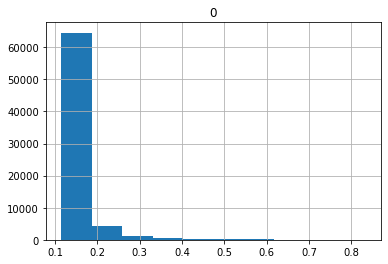

In [39]:
pd.DataFrame(abortion).hist()

In [40]:
interaction = 1
initial_passed = passed
print("initial_passed:", initial_passed)
print("")
while math.fabs(passed/len(correct)*100.-coverage) > 0.3:
    print("interaction", interaction)
    if passed/len(correct)*100.>coverage:
        upper = min(test_thres,upper)
        test_thres=(test_thres+lower)/2
    elif passed/len(correct)*100. < coverage:
        lower = max(test_thres,lower)
        test_thres=(test_thres+upper)/2
    print("upper", upper)
    print("lower", lower)
    mask = abortion <=  test_thres
    passed = torch.sum(mask.long()).item()
    print("passed", passed)
    print("test_thres", test_thres)
    df_mask = pd.DataFrame(mask).describe()
    print("")
    print("df_mask", df_mask)
    print("While condition", math.fabs(passed/len(correct)*100.-coverage) > 0.3)
    print("-----------------")

initial_passed: 71257

interaction 1
upper 1.0
lower 0.0
passed 70869
test_thres 0.5

df_mask             0
count   71257
unique      2
top      True
freq    70869
While condition True
-----------------
interaction 1
upper 0.5
lower 0.0
passed 68681
test_thres 0.25

df_mask             0
count   71257
unique      2
top      True
freq    68681
While condition True
-----------------
interaction 1
upper 0.25
lower 0.0
passed 1289
test_thres 0.125

df_mask             0
count   71257
unique      2
top     False
freq    69968
While condition True
-----------------
interaction 1
upper 0.25
lower 0.125
passed 64614
test_thres 0.1875

df_mask             0
count   71257
unique      2
top      True
freq    64614
While condition True
-----------------
interaction 1
upper 0.1875
lower 0.125
passed 35845
test_thres 0.15625

df_mask             0
count   71257
unique      2
top      True
freq    35845
While condition True
-----------------
interaction 1
upper 0.1875
lower 0.15625
passed 60592
test_

In [41]:
test_thres

0.18359375

In [42]:
count_true, count_false = pd.DataFrame(abortion < test_thres).value_counts()

The bissection method will find what is the threshold that will give the desired coverage

In [43]:
print(count_true/(len(abortion)))

0.897610059362589


In [44]:
passed

63961

In [45]:
masked_correct = correct[mask]
correct_data = torch.sum(masked_correct.long()).item()
passed_acc = correct_data/passed
print((passed/len(correct), passed_acc))

(0.897610059362589, 0.997451572051719)


Calculating coverage, error and thresholds

In [46]:
bisection_method(abortion_valid, correct_valid, results_valid)
bisection_method(abortion, correct, results)

In [47]:
print("Vali\tCoverage\tError")
for idx, _ in enumerate(results_valid):
    print('{:.0f},\t{:.2f},\t\t{:.3f},\t\t{:.3f}'.format(expected_coverage[idx], results_valid[idx][0]*100., (1 - results_valid[idx][1])*100, results_valid[idx][2]))
print("\nTest\tCoverage\tError")
for idx, _ in enumerate(results):
    print('{:.0f},\t{:.2f},\t\t{:.3f}'.format(expected_coverage[idx], results[idx][0]*100., (1 - results[idx][1])*100, results[idx][2]))

Vali	Coverage	Error
100,	100.00,		0.750,		1.000
99,	98.75,		0.506,		0.375
98,	98.00,		0.459,		0.340
97,	97.05,		0.412,		0.297
95,	95.30,		0.420,		0.242
90,	90.05,		0.333,		0.189
85,	85.20,		0.293,		0.174
80,	79.80,		0.313,		0.167
75,	75.05,		0.266,		0.164
70,	69.95,		0.286,		0.162
60,	59.90,		0.167,		0.159
50,	50.20,		0.199,		0.156
40,	39.70,		0.252,		0.154
30,	29.85,		0.335,		0.151
20,	20.15,		0.496,		0.147
10,	9.85,		0.508,		0.138

Test	Coverage	Error
100,	100.00,		0.776
99,	98.72,		0.385
98,	98.17,		0.346
97,	96.98,		0.305
95,	95.08,		0.272
90,	90.00,		0.254
85,	84.82,		0.238
80,	80.05,		0.230
75,	74.92,		0.221
70,	70.01,		0.206
60,	59.94,		0.197
50,	50.14,		0.207
40,	40.20,		0.189
30,	30.24,		0.186
20,	20.30,		0.194
10,	9.77,		0.144
